# Import Functions

In [1]:
#Import packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from numpy import hstack
import random
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import IEX functions
from iexfinance.stocks import get_historical_data
from iexfinance.stocks import get_historical_intraday
from iexfinance.stocks import Stock
from datetime import datetime
from datetime import date
import datetime
from datetime import timedelta
import os

# Fetch the data

In [3]:
# Definfe the stock and ETFs universe
ETFs_universe = ['MGC', 'MGK', 'MTUM', 'MGV', 'QQQ', 'SDY', 'SPLV', 'VB',
                 'VIG', 'VHT', 'VDE', 'VFH', 'VGT', 'VDC', 'VCR', 'VBR', 'VBK',
                 'VIS', 'VNQ', 'VO', 'VOE', 'VOT', 'VOX', 'VPU', 'VTV', 'VUG',
                 'VV', 'VYM', 'XBI', 'XLB', 'XLC', 'XLI', 'XLK', 'XLV', 'XME'
                 ]



# Authenticate the IEX with token
os.environ['IEX_API_VERSION'] = 'iexcloud-sandbox'
os.environ['IEX_TOKEN'] = 'Tpk_6444c7727b7f41b0bfcc9962e52bb8cf'

# Fetch the data from IEX
start_date = datetime.date.today()  - timedelta(days = 365*10)
data = []

In [27]:
df = pd.DataFrame(columns=['symbol', 'fClose', 'changePercent'])
return_table = pd.DataFrame()
today = datetime.date.today()

for s in ETFs_universe:
    df_extract = get_historical_data(s, start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
    previous_price = df_extract.fClose[-1]
    lastest_price = get_historical_intraday(s, today).average.dropna()
    
    if lastest_price.empty:
        lastest_price = previous_price
    else:
        lastest_price = lastest_price[-1]

    lastest_return = (lastest_price - previous_price)/previous_price
    df_extract.loc[today] = [s, lastest_price, lastest_return]
    
    return_table[s] = pd.to_numeric(df_extract.changePercent)
    df = df.append(df_extract)


# reindex    
return_table['index'] = pd.to_datetime(return_table.index, format = '%Y-%m-%d')
return_table = return_table.set_index('index') 

# normalize the data
normalized_table = (return_table - return_table.mean())/return_table.std()
normalized_table = normalized_table.fillna(0)

# Change datatype into numeric
df.fClose = pd.to_numeric(df.fClose)
df.head()

,symbol,fClose,changePercent
2011-07-12 00:00:00,MGC,37.4659,-0.004
2011-07-13 00:00:00,MGC,37.4823,0.0032
2011-07-14 00:00:00,MGC,38.0578,-0.006
2011-07-15 00:00:00,MGC,37.3623,0.005
2011-07-18 00:00:00,MGC,38.0203,-0.009


# Momentum Functions

In [28]:
def cumulative_return(return_vals):
    cumulative_return_list = (np.array(return_vals)+1).cumprod() -1
    
    return cumulative_return_list[-1]

def resample_return_table(df, t):
    # df is the daily return table
    # t is the number of week we want to resample into
    df = df.fillna(0)
    df = df.resample("W-Fri").apply(lambda x : cumulative_return(x)) # turn the dataframe into weekly 
    index = df.index # store the weekly datetime index
    df = df.reset_index().drop(columns=['index'])

    rolling_return = (1 + df).rolling(window = t).apply(np.prod, raw = True) - 1
    rolling_return = rolling_return.set_index([index])
    return rolling_return.iloc[::-1].iloc[::t, :].iloc[::-1] # turn the table upside dowm, then select every t-th row, the turn around the table again 

def resample_risk_adjusted_return_table(df, t):
    # for ranking propose, we need risk adjusted return
    df = df.fillna(0)
    idx = pd.date_range(df.index[0], df.index[-1])
    
    risk = df.reindex(idx, fill_value=0).rolling(window=t*5).std()
    df = df.resample("W-Fri").apply(lambda x : cumulative_return(x))# turn the dataframe into weekly
    index = df.index # store the weekly datetime index
    df = df.reset_index().drop(columns=['index'])
    
    rolling_return = (1 + df).rolling(window = t).apply(np.prod, raw = True) - 1
    rolling_return = rolling_return.set_index([index])
    resample_return_table = rolling_return.iloc[::-1].iloc[::t, :].iloc[::-1]
    multrisk = resample_return_table.mul(1/risk).dropna(how='all') # multiply element-wise 
    # using ,mul instead of np.multiply, and you can multiply 2 dataframe with different dimension
    return multrisk

def momemtum_ranking_table(df, t, n):
    # use only in simple momentum model, not lstm or transformer
    # lookback period = t weeks
    # select top n stock
    
    # create a ranking table (smaller the ranking, higher the return)
    # shift(1) here since we make our decision based on the previous return
    ranking = resample_risk_adjusted_return_table(df, t).shift(1).rank(axis=1, na_option='keep', ascending = False)
    original_rank = list(range (1, len(df.columns)+1))
    replace_rank = [1]*n + [0]*(len(df.columns)-n)

    ranking_matrix = ranking.replace(original_rank, replace_rank)# replace_rank
    return ranking_matrix

def momemtum_ranking_table_for_predict_return(df, t, n):
    # the difference between momemtum ranking table is do the shift(1) or not.
    # instead of using the previous real return, we are using the current prediction return as proxy to select the winners
    
    ranking = resample_risk_adjusted_return_table(df, t).rank(axis=1, na_option='keep', ascending = False)
    original_rank = list(range (1, len(df.columns)+1))
    replace_rank = [1]*n + [0]*(len(df.columns)-n)

    ranking_matrix = ranking.replace(original_rank, replace_rank)# replace_rank
    return ranking_matrix
    
def portfolio_return_table(df, t, n):
    return momemtum_ranking_table(df, t, n).mul(resample_return_table(df, t)).sum(1)*(1/n) # equal weighted here

def portfolio_return_table_for_prediction(original_df, predict_df, t, n):
    return momemtum_ranking_table_for_predict_return(predict_df, t, n).mul(resample_return_table(original_df, t)).sum(1)*(1/n) # equal weighted here
    
def plot_maximum_drawdown(df, t, n):
    wealth_index=(1+portfolio_return_table(df,t,n)).cumprod()
    plt.plot(wealth_index)
    previous_peaks = pd.Series(wealth_index).cummax()
    previous_peaks.plot()

# Univariate LSTM

In [29]:
class DataPreprocess():
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_len = seq_length
        self.trainX = None
        self.trainY = None
        self.testX = None
        self.testY = None
        self.scaler = None
        self.date = list(data.index)
        self.indexY = []

    def sliding_windows(self): #create dataset, seq_len is the lookback period
        x = []
        y = []
        for i in range(len(self.data)-self.seq_len):
            _x = self.data[i:(i+self.seq_len)]
            _y = self.data[i+self.seq_len]
            x.append(_x)
            y.append(_y)
            #print(_x)
            print(_y)
            self.indexY.append(self.date[i+self.seq_len])
        return np.array(x),np.array(y)
    
    def split_train_test(self, split_percentage = 0.9):
        sc = MinMaxScaler()
        self.data = self.data.values.reshape(-1, 1)
        self.data = sc.fit_transform(self.data)
        self.scaler = sc 
        x, y = self.sliding_windows()

        train_size = int(len(y) * split_percentage)
        test_size = len(y) - train_size

        dataX = Variable(torch.Tensor(np.array(x)))
        dataY = Variable(torch.Tensor(np.array(y)))

        self.trainX = Variable(torch.Tensor(np.array(x[:train_size])))
        self.trainY = Variable(torch.Tensor(np.array(y[:train_size])))

        self.testX = Variable(torch.Tensor(np.array(x[train_size:])))
        self.testY = Variable(torch.Tensor(np.array(y[train_size:])))
        self.test_index = self.indexY[train_size:]

    def get_training_data(self):
        return self.trainX, self.trainY 
    
    def get_testing_data(self):
        return self.testX, self.testY

In [30]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [31]:
def training(model, num_epochs, learning_rate, trainX, trainY):
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = model(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))
    
def predict(model, testing_data, scaler):
    sc = MinMaxScaler()
    predict = model(testing_data)
    predict = predict.data.numpy()
    scaled_pred = scaler.inverse_transform(predict)
    pred_list = list(scaled_pred.reshape(1, -1)[0])
    return pred_list

In [33]:
# Run the model

num_epochs = 100
learning_rate = 0.001
input_size = 1
hidden_size = 32
num_layers = 1
num_classes = 1
models = {}
ts_data = {}
LSTM_prediction_return_table = pd.DataFrame()

for ticker in normalized_table.columns:
    print(ticker)
    data = DataPreprocess(normalized_table[ticker], 25)
    data.split_train_test()
    ts_data[ticker] = data
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
    training(lstm, num_epochs, learning_rate, data.trainX, data.trainY)
    models[ticker] = lstm
    pred = predict(lstm, data.testX, data.scaler)
    LSTM_prediction_return_table[ticker] = pred

MGC
[0.52146119]
[0.55525114]
[0.36438356]
[0.4739726]
[0.56210046]
[0.70821918]
[0.62100457]
[0.48173516]
[0.62328767]
[0.69178082]
[0.56438356]
[0.57853881]
[0.51050228]
[0.43059361]
[0.52511416]
[0.68401826]
[0.51506849]
[0.43333333]
[0.58858447]
[0.59452055]
[0.62146119]
[0.63926941]
[0.5826484]
[0.51826484]
[0.54931507]
[0.41369863]
[0.41552511]
[0.55479452]
[0.66803653]
[0.60182648]
[0.46575342]
[0.59041096]
[0.44429224]
[0.42968037]
[0.65159817]
[0.64429224]
[0.64292237]
[0.52146119]
[0.71598174]
[0.55707763]
[0.60730594]
[0.5369863]
[0.63333333]
[0.4652968]
[0.65022831]
[0.50091324]
[0.57488584]
[0.64474886]
[0.6109589]
[0.46255708]
[0.6086758]
[0.71278539]
[0.55525114]
[0.44018265]
[0.42511416]
[0.62968037]
[0.64474886]
[0.52237443]
[0.59223744]
[0.61278539]
[0.39452055]
[0.59223744]
[0.64703196]
[0.51415525]
[0.57671233]
[0.48082192]
[0.47808219]
[0.55525114]
[0.46575342]
[0.53926941]
[0.45159817]
[0.55159817]
[0.67808219]
[0.56986301]
[0.75844749]
[0.54246575]
[0.55799087]
[

[0.51552511]
[0.56757991]
[0.52054795]
[0.54748858]
[0.61872146]
[0.57305936]
[0.5543379]
[0.60136986]
[0.60228311]
[0.56666667]
[0.56484018]
[0.52146119]
[0.57625571]
[0.55022831]
[0.54429224]
[0.58995434]
[0.54703196]
[0.57077626]
[0.54292237]
[0.54840183]
[0.5]
[0.61917808]
[0.52739726]
[0.60684932]
[0.58082192]
[0.55936073]
[0.59360731]
[0.55616438]
[0.57077626]
[0.56210046]
[0.56027397]
[0.53972603]
[0.56986301]
[0.55296804]
[0.54383562]
[0.53789954]
[0.5630137]
[0.52557078]
[0.56027397]
[0.49452055]
[0.56621005]
[0.52511416]
[0.55616438]
[0.56164384]
[0.56894977]
[0.53424658]
[0.59726027]
[0.59406393]
[0.60045662]
[0.5716895]
[0.52374429]
[0.60045662]
[0.55981735]
[0.55525114]
[0.57579909]
[0.5652968]
[0.53333333]
[0.55479452]
[0.56666667]
[0.5826484]
[0.59726027]
[0.53881279]
[0.52557078]
[0.53013699]
[0.57762557]
[0.55525114]
[0.57853881]
[0.5803653]
[0.5739726]
[0.57260274]
[0.55570776]
[0.54840183]
[0.52374429]
[0.53881279]
[0.58493151]
[0.52374429]
[0.59269406]
[0.56940639]


Epoch: 100, loss: 0.00261
MGK
[0.54529464]
[0.56596306]
[0.37554969]
[0.48944591]
[0.58970976]
[0.71547933]
[0.6473175]
[0.50659631]
[0.65831135]
[0.69700967]
[0.59014952]
[0.59146878]
[0.53210202]
[0.46789798]
[0.55452946]
[0.6882146]
[0.54485488]
[0.4525066]
[0.60422164]
[0.62313105]
[0.64423923]
[0.64907652]
[0.60378188]
[0.55584872]
[0.56288478]
[0.45426561]
[0.43095866]
[0.58223395]
[0.66402814]
[0.61653474]
[0.48724714]
[0.57080035]
[0.46042216]
[0.45734389]
[0.6710642]
[0.6701847]
[0.65787159]
[0.55189094]
[0.71899736]
[0.59542656]
[0.60510114]
[0.58135444]
[0.66226913]
[0.48724714]
[0.64555849]
[0.50219877]
[0.58399296]
[0.66270888]
[0.63720317]
[0.49648197]
[0.60158311]
[0.70976253]
[0.58619173]
[0.4885664]
[0.45426561]
[0.6416007]
[0.65787159]
[0.54969217]
[0.60246262]
[0.6350044]
[0.42084433]
[0.60334213]
[0.66270888]
[0.5466139]
[0.60773967]
[0.50131926]
[0.49824099]
[0.56068602]
[0.49516271]
[0.57211961]
[0.48021108]
[0.55716799]
[0.7062445]
[0.58135444]
[0.75109938]
[0.58

[0.56992084]
[0.55936675]
[0.60729991]
[0.55980651]
[0.57343887]
[0.64511873]
[0.59938434]
[0.57299912]
[0.62401055]
[0.61609499]
[0.57871592]
[0.5760774]
[0.53078276]
[0.59806508]
[0.5703606]
[0.56992084]
[0.6055409]
[0.55408971]
[0.60466139]
[0.57343887]
[0.56948109]
[0.53957784]
[0.62225154]
[0.56112577]
[0.62796834]
[0.60949868]
[0.58575198]
[0.60993843]
[0.55540897]
[0.58399296]
[0.58619173]
[0.59190853]
[0.55716799]
[0.61037819]
[0.5703606]
[0.5703606]
[0.54969217]
[0.59234828]
[0.54397537]
[0.57431838]
[0.4885664]
[0.59674582]
[0.52682498]
[0.59850484]
[0.57959543]
[0.59498681]
[0.53825858]
[0.61873351]
[0.62576957]
[0.61433597]
[0.58619173]
[0.55189094]
[0.62576957]
[0.58223395]
[0.56420405]
[0.60070361]
[0.57387863]
[0.55936675]
[0.56992084]
[0.5760774]
[0.60158311]
[0.62796834]
[0.52110818]
[0.53210202]
[0.52242744]
[0.60114336]
[0.59058927]
[0.61389622]
[0.58619173]
[0.59674582]
[0.58883026]
[0.57519789]
[0.5703606]
[0.54485488]
[0.56772208]
[0.60114336]
[0.53430079]
[0.5985

Epoch: 100, loss: 0.00267
MTUM
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.54371874]
[0.5437

[0.61265498]
[0.54339461]
[0.50876443]
[0.56861907]
[0.5019239]
[0.55066268]
[0.58743053]
[0.57503206]
[0.55921334]
[0.59683625]
[0.57075673]
[0.54382215]
[0.54168448]
[0.51346729]
[0.55921334]
[0.53014109]
[0.53398888]
[0.58486533]
[0.52372809]
[0.55921334]
[0.53869175]
[0.52800342]
[0.48525011]
[0.59940145]
[0.4980761]
[0.60923472]
[0.5716118]
[0.56177854]
[0.58358273]
[0.5019239]
[0.55579307]
[0.53698162]
[0.55280034]
[0.53954681]
[0.55964087]
[0.52885849]
[0.54553228]
[0.51218469]
[0.5651988]
[0.49978623]
[0.5083369]
[0.44420693]
[0.54809748]
[0.47926464]
[0.58999572]
[0.54895254]
[0.55921334]
[0.50491663]
[0.57118427]
[0.58101753]
[0.59170586]
[0.55194528]
[0.51817016]
[0.60068405]
[0.53441642]
[0.54339461]
[0.56434374]
[0.55151774]
[0.51090209]
[0.54467721]
[0.54852501]
[0.53740915]
[0.59940145]
[0.52800342]
[0.47327918]
[0.46472852]
[0.55750321]
[0.55023514]
[0.58572039]
[0.54211201]
[0.56348867]
[0.56220607]
[0.54895254]
[0.54168448]
[0.51945276]
[0.52116289]
[0.57118427]
[0.48

Epoch: 100, loss: 0.00217
MGV
[0.48264059]
[0.5207824]
[0.31344743]
[0.43667482]
[0.50366748]
[0.65770171]
[0.58728606]
[0.44645477]
[0.55501222]
[0.6601467]
[0.51638142]
[0.53300733]
[0.44987775]
[0.38777506]
[0.45281174]
[0.6601467]
[0.45378973]
[0.37555012]
[0.54718826]
[0.5398533]
[0.57114914]
[0.60146699]
[0.53838631]
[0.44303178]
[0.51491443]
[0.34963325]
[0.3599022]
[0.49633252]
[0.64205379]
[0.56870416]
[0.4200489]
[0.59070905]
[0.40488998]
[0.35794621]
[0.61760391]
[0.59217604]
[0.59657702]
[0.4606357]
[0.68117359]
[0.4997555]
[0.57799511]
[0.46943765]
[0.58679707]
[0.40782396]
[0.63569682]
[0.47383863]
[0.54425428]
[0.60195599]
[0.55745721]
[0.40488998]
[0.59315403]
[0.68264059]
[0.50464548]
[0.38875306]
[0.34376528]
[0.59462103]
[0.59022005]
[0.47481663]
[0.55354523]
[0.57310513]
[0.33447433]
[0.5599022]
[0.599511]
[0.45721271]
[0.5202934]
[0.42640587]
[0.42249389]
[0.5403423]
[0.40537897]
[0.48166259]
[0.39413203]
[0.51540342]
[0.62396088]
[0.54474328]
[0.74180929]
[0.49144

[0.5198044]
[0.53545232]
[0.52127139]
[0.45085575]
[0.50268949]
[0.4596577]
[0.49193154]
[0.56332518]
[0.5193154]
[0.51246944]
[0.55403423]
[0.5599022]
[0.53056235]
[0.52567237]
[0.48508557]
[0.52909535]
[0.50220049]
[0.49633252]
[0.55403423]
[0.50415648]
[0.50904645]
[0.49193154]
[0.49828851]
[0.43569682]
[0.58533007]
[0.47383863]
[0.55647922]
[0.5202934]
[0.50953545]
[0.55794621]
[0.52860636]
[0.52420538]
[0.51687042]
[0.50317848]
[0.48997555]
[0.50709046]
[0.50366748]
[0.49095355]
[0.50122249]
[0.50513447]
[0.48264059]
[0.53056235]
[0.46405868]
[0.51246944]
[0.4792176]
[0.50415648]
[0.51100244]
[0.52469438]
[0.49828851]
[0.54914425]
[0.5398533]
[0.55501222]
[0.53545232]
[0.47090465]
[0.54621027]
[0.51295844]
[0.51735941]
[0.52224939]
[0.53105134]
[0.48264059]
[0.51295844]
[0.52811736]
[0.54229829]
[0.54718826]
[0.52469438]
[0.49828851]
[0.50709046]
[0.52860636]
[0.49193154]
[0.52224939]
[0.54767726]
[0.52567237]
[0.52958435]
[0.50709046]
[0.4992665]
[0.48166259]
[0.48166259]
[0.5418

Epoch: 100, loss: 0.00294
QQQ
[0.55092373]
[0.56276646]
[0.3472288]
[0.50355282]
[0.60871625]
[0.79014685]
[0.62813832]
[0.51207958]
[0.71151113]
[0.72430128]
[0.62340123]
[0.59876836]
[0.54666035]
[0.47939365]
[0.59213643]
[0.71198484]
[0.56892468]
[0.48507816]
[0.6527712]
[0.65466604]
[0.66035054]
[0.66461393]
[0.6271909]
[0.59308385]
[0.57034581]
[0.50828991]
[0.43344387]
[0.64329702]
[0.64661298]
[0.64092847]
[0.52060635]
[0.53292279]
[0.46707721]
[0.46897205]
[0.69019422]
[0.7148271]
[0.67408811]
[0.5594505]
[0.76314543]
[0.62387494]
[0.61487447]
[0.63666509]
[0.68214117]
[0.51539555]
[0.65229749]
[0.49928944]
[0.56702984]
[0.65324491]
[0.68972051]
[0.49407864]
[0.5855045]
[0.7252487]
[0.59876836]
[0.50971104]
[0.46186641]
[0.63287541]
[0.69019422]
[0.56608243]
[0.62576978]
[0.64708669]
[0.41733775]
[0.58882046]
[0.684036]
[0.56087162]
[0.64566556]
[0.51113216]
[0.47986736]
[0.55329228]
[0.4973946]
[0.60729512]
[0.47939365]
[0.55329228]
[0.76077688]
[0.56087162]
[0.76646139]
[0.62

[0.48602558]
[0.59734723]
[0.69351018]
[0.59403126]
[0.55660824]
[0.6475604]
[0.56229275]
[0.5907153]
[0.68593084]
[0.631928]
[0.58645192]
[0.64424443]
[0.64187589]
[0.58692563]
[0.59971577]
[0.53623875]
[0.62292752]
[0.57224064]
[0.56655613]
[0.61819043]
[0.58455708]
[0.63287541]
[0.58976788]
[0.5959261]
[0.56939839]
[0.62576978]
[0.58834676]
[0.66603505]
[0.63382283]
[0.60587399]
[0.61961156]
[0.55139744]
[0.59166272]
[0.60397916]
[0.61629559]
[0.5907153]
[0.63950734]
[0.57413548]
[0.57839886]
[0.57745144]
[0.6267172]
[0.54855519]
[0.5802937]
[0.47986736]
[0.61108479]
[0.52392231]
[0.63287541]
[0.60397916]
[0.62340123]
[0.53339649]
[0.65229749]
[0.66745618]
[0.63382283]
[0.59450497]
[0.56608243]
[0.67408811]
[0.59497868]
[0.57934628]
[0.62008527]
[0.58171483]
[0.56750355]
[0.59024159]
[0.6063477]
[0.61108479]
[0.65750829]
[0.51681667]
[0.52392231]
[0.52202748]
[0.62861203]
[0.61013738]
[0.65656087]
[0.6063477]
[0.61961156]
[0.60824254]
[0.59734723]
[0.58834676]
[0.55329228]
[0.585978

Epoch: 100, loss: 0.00353
SDY
[0.48001926]
[0.50312951]
[0.35002407]
[0.46461242]
[0.51757342]
[0.65719788]
[0.58449687]
[0.42465094]
[0.56475686]
[0.63986519]
[0.51612903]
[0.53635051]
[0.45594608]
[0.3986519]
[0.47087145]
[0.63360616]
[0.46268657]
[0.37698604]
[0.52479538]
[0.55079442]
[0.58305248]
[0.56234954]
[0.49205585]
[0.46027925]
[0.50698122]
[0.34376505]
[0.3827636]
[0.54164661]
[0.60808859]
[0.57775638]
[0.38468946]
[0.59845932]
[0.4092441]
[0.36591237]
[0.63890226]
[0.57438613]
[0.57727492]
[0.4675012]
[0.64323544]
[0.49446317]
[0.54742417]
[0.48675975]
[0.56909003]
[0.42368801]
[0.61675494]
[0.46942706]
[0.52816562]
[0.62445835]
[0.53153587]
[0.41839191]
[0.55175734]
[0.6066442]
[0.52238806]
[0.41309581]
[0.37313433]
[0.58353394]
[0.60712566]
[0.48724121]
[0.5272027]
[0.55753491]
[0.34424651]
[0.5589793]
[0.59412614]
[0.4675012]
[0.52431391]
[0.44727973]
[0.45787193]
[0.51227732]
[0.41165142]
[0.50024073]
[0.40683678]
[0.5060183]
[0.61819933]
[0.53972075]
[0.67645643]
[0.4

[0.51179586]
[0.47713048]
[0.51998074]
[0.52961001]
[0.52383245]
[0.45835339]
[0.50746269]
[0.4675012]
[0.48242658]
[0.56860857]
[0.51324025]
[0.49879634]
[0.53153587]
[0.54116514]
[0.51083293]
[0.4992778]
[0.48001926]
[0.52768416]
[0.51179586]
[0.50746269]
[0.54790563]
[0.48820414]
[0.5045739]
[0.50649976]
[0.49975927]
[0.47664901]
[0.57823784]
[0.44824266]
[0.52286952]
[0.53009148]
[0.50746269]
[0.5324988]
[0.52238806]
[0.52672123]
[0.50890708]
[0.5166105]
[0.46846413]
[0.52046221]
[0.4886856]
[0.48435243]
[0.49687049]
[0.51805489]
[0.47905633]
[0.52479538]
[0.49253731]
[0.50409244]
[0.48050072]
[0.52961001]
[0.50649976]
[0.4992778]
[0.52335099]
[0.54935002]
[0.53201733]
[0.51757342]
[0.53490611]
[0.46798267]
[0.51179586]
[0.51564757]
[0.48579682]
[0.51805489]
[0.51179586]
[0.52527684]
[0.50264805]
[0.49446317]
[0.51420318]
[0.52527684]
[0.54549831]
[0.48194511]
[0.51083293]
[0.55031295]
[0.47038999]
[0.53153587]
[0.54694271]
[0.51901781]
[0.50842561]
[0.49494463]
[0.50312951]
[0.469

Epoch: 100, loss: 0.00285
SPLV
[0.55579965]
[0.58435852]
[0.46792619]
[0.53163445]
[0.57073814]
[0.67442882]
[0.62653779]
[0.49209139]
[0.60061511]
[0.67003515]
[0.57469244]
[0.5887522]
[0.53339192]
[0.49253076]
[0.54393673]
[0.64982425]
[0.54789104]
[0.46528998]
[0.58611599]
[0.59622144]
[0.61775044]
[0.60676626]
[0.59753954]
[0.53998243]
[0.59710018]
[0.47363796]
[0.4771529]
[0.58435852]
[0.65158172]
[0.59314587]
[0.51493849]
[0.61335677]
[0.51493849]
[0.47188049]
[0.61379613]
[0.59226714]
[0.62829525]
[0.55755712]
[0.66959578]
[0.54261863]
[0.58172232]
[0.56151142]
[0.59753954]
[0.52372583]
[0.62785589]
[0.54964851]
[0.5940246]
[0.64806678]
[0.5685413]
[0.50790861]
[0.59622144]
[0.66695958]
[0.5470123]
[0.50966608]
[0.47495606]
[0.61511424]
[0.63488576]
[0.54217926]
[0.58655536]
[0.60676626]
[0.45123023]
[0.60676626]
[0.62741652]
[0.52680141]
[0.5685413]
[0.50966608]
[0.53295255]
[0.58347979]
[0.50966608]
[0.54173989]
[0.50087873]
[0.57644991]
[0.64411248]
[0.59753954]
[0.70210896]


[0.53514938]
[0.55360281]
[0.52328647]
[0.56282953]
[0.60764499]
[0.57864675]
[0.54042179]
[0.56502636]
[0.52768014]
[0.57425308]
[0.60588752]
[0.57161687]
[0.54217926]
[0.58523726]
[0.60544815]
[0.57469244]
[0.5483304]
[0.53383128]
[0.56107206]
[0.55931459]
[0.5685413]
[0.58479789]
[0.55755712]
[0.59226714]
[0.57073814]
[0.57073814]
[0.53602812]
[0.62785589]
[0.53295255]
[0.57688928]
[0.57908612]
[0.55404218]
[0.57073814]
[0.57469244]
[0.58435852]
[0.55667838]
[0.58391916]
[0.54261863]
[0.58699473]
[0.58435852]
[0.54393673]
[0.56678383]
[0.56678383]
[0.55140598]
[0.5940246]
[0.57161687]
[0.56326889]
[0.54086116]
[0.59534271]
[0.57029877]
[0.57337434]
[0.57161687]
[0.60061511]
[0.58655536]
[0.543058]
[0.59490334]
[0.5659051]
[0.59534271]
[0.56766257]
[0.55492091]
[0.57732865]
[0.56326889]
[0.57205624]
[0.54920914]
[0.54481547]
[0.57952548]
[0.60456942]
[0.59753954]
[0.54481547]
[0.54042179]
[0.62873462]
[0.55008787]
[0.56414763]
[0.60632689]
[0.57293497]
[0.56414763]
[0.55667838]
[0.56

Epoch: 100, loss: 0.00198
VB
[0.49397089]
[0.55010395]
[0.31392931]
[0.48690229]
[0.56008316]
[0.75467775]
[0.62453222]
[0.46611227]
[0.66361746]
[0.75925156]
[0.58295218]
[0.56881497]
[0.48565489]
[0.40914761]
[0.54178794]
[0.73097713]
[0.48856549]
[0.44116424]
[0.5954262]
[0.64033264]
[0.63534304]
[0.62453222]
[0.57089397]
[0.4989605]
[0.4989605]
[0.402079]
[0.41954262]
[0.61288981]
[0.64282744]
[0.64740125]
[0.40623701]
[0.62162162]
[0.43575884]
[0.35550936]
[0.78794179]
[0.64158004]
[0.66902287]
[0.46735967]
[0.74012474]
[0.58212058]
[0.61995842]
[0.55966736]
[0.64781705]
[0.43991684]
[0.67359667]
[0.48565489]
[0.58627859]
[0.64656965]
[0.70519751]
[0.44989605]
[0.63201663]
[0.77130977]
[0.55051975]
[0.45530146]
[0.42079002]
[0.65904366]
[0.67068607]
[0.54386694]
[0.55634096]
[0.61787942]
[0.37837838]
[0.59085239]
[0.67110187]
[0.50852391]
[0.60706861]
[0.49355509]
[0.4993763]
[0.55841996]
[0.47193347]
[0.53430353]
[0.43908524]
[0.52349272]
[0.74178794]
[0.56216216]
[0.79168399]
[0

[0.53679834]
[0.54095634]
[0.56133056]
[0.53305613]
[0.56299376]
[0.58253638]
[0.55800416]
[0.52557173]
[0.57588358]
[0.56382536]
[0.55093555]
[0.61954262]
[0.5966736]
[0.58045738]
[0.59251559]
[0.58544699]
[0.57089397]
[0.55426195]
[0.55841996]
[0.595842]
[0.57713098]
[0.56465696]
[0.59417879]
[0.53139293]
[0.56756757]
[0.56798337]
[0.55883576]
[0.55218295]
[0.62370062]
[0.52681913]
[0.5950104]
[0.58295218]
[0.58253638]
[0.5991684]
[0.55301455]
[0.57837838]
[0.57255717]
[0.58045738]
[0.53929314]
[0.57837838]
[0.55883576]
[0.58004158]
[0.55634096]
[0.59251559]
[0.52182952]
[0.55093555]
[0.49438669]
[0.58461538]
[0.50602911]
[0.58544699]
[0.56299376]
[0.58004158]
[0.57546778]
[0.6024948]
[0.6012474]
[0.5962578]
[0.55384615]
[0.53139293]
[0.58711019]
[0.55675676]
[0.54345114]
[0.58419958]
[0.57713098]
[0.58212058]
[0.54844075]
[0.56091476]
[0.52182952]
[0.58835759]
[0.58212058]
[0.4993763]
[0.53139293]
[0.6049896]
[0.56507277]
[0.6]
[0.55966736]
[0.58794179]
[0.57297297]
[0.55550936]
[0.

Epoch: 100, loss: 0.00296
VIG
[0.51617796]
[0.5429727]
[0.34883721]
[0.48634985]
[0.55611729]
[0.70475228]
[0.60010111]
[0.4570273]
[0.60667341]
[0.67138524]
[0.55106168]
[0.56825076]
[0.48988878]
[0.42467139]
[0.50404449]
[0.67239636]
[0.48736097]
[0.40343782]
[0.56521739]
[0.58493428]
[0.62285137]
[0.62386249]
[0.56319515]
[0.49393327]
[0.54196158]
[0.40141557]
[0.35844287]
[0.53286148]
[0.67340748]
[0.60566229]
[0.43478261]
[0.59605662]
[0.44084934]
[0.40546006]
[0.65065723]
[0.61476239]
[0.6107179]
[0.52325581]
[0.69261881]
[0.53791709]
[0.58139535]
[0.52325581]
[0.62285137]
[0.44843276]
[0.64004044]
[0.50960566]
[0.56420627]
[0.65824065]
[0.58139535]
[0.44994944]
[0.5793731]
[0.68503539]
[0.53842265]
[0.42517695]
[0.41304348]
[0.63650152]
[0.63195147]
[0.52275025]
[0.56976744]
[0.59908999]
[0.37209302]
[0.59150657]
[0.6445905]
[0.50556117]
[0.55712841]
[0.46814965]
[0.4726997]
[0.5520728]
[0.44843276]
[0.53235592]
[0.44034378]
[0.53336704]
[0.67694641]
[0.57229525]
[0.73811931]
[0

[0.54903943]
[0.51061678]
[0.49544995]
[0.54701719]
[0.46157735]
[0.54802831]
[0.570273]
[0.54701719]
[0.50050556]
[0.52072801]
[0.49292214]
[0.52932255]
[0.60717897]
[0.54802831]
[0.54600607]
[0.57532861]
[0.57987867]
[0.5611729]
[0.54044489]
[0.51314459]
[0.56926188]
[0.54246714]
[0.54347826]
[0.58392315]
[0.50960566]
[0.56420627]
[0.55308392]
[0.53336704]
[0.48634985]
[0.61122346]
[0.48331648]
[0.59150657]
[0.5677452]
[0.54550051]
[0.57633974]
[0.54701719]
[0.56521739]
[0.53589484]
[0.53943377]
[0.52376138]
[0.54752275]
[0.55712841]
[0.51365015]
[0.51061678]
[0.54196158]
[0.5156724]
[0.55662285]
[0.49949444]
[0.54145602]
[0.49646107]
[0.51971689]
[0.55460061]
[0.54499494]
[0.53185035]
[0.57836198]
[0.56471183]
[0.5859454]
[0.57229525]
[0.49797776]
[0.57633974]
[0.56370071]
[0.52072801]
[0.58088979]
[0.55257836]
[0.53488372]
[0.54499494]
[0.53538928]
[0.54600607]
[0.58392315]
[0.56370071]
[0.52123357]
[0.51466127]
[0.58291203]
[0.50353893]
[0.55460061]
[0.56572295]
[0.55460061]
[0.55

Epoch: 100, loss: 0.00276
VHT
[0.57625384]
[0.58444217]
[0.40225179]
[0.56397134]
[0.5962129]
[0.76151484]
[0.65301945]
[0.50460594]
[0.6642784]
[0.73746162]
[0.61054248]
[0.6223132]
[0.53787103]
[0.48055271]
[0.59979529]
[0.73387922]
[0.53224156]
[0.43551689]
[0.604913]
[0.64841351]
[0.65353122]
[0.64585466]
[0.61105425]
[0.54708291]
[0.62640737]
[0.45957011]
[0.47799386]
[0.61105425]
[0.67093142]
[0.67400205]
[0.48925281]
[0.62538383]
[0.52302968]
[0.41095189]
[0.6591607]
[0.68423746]
[0.65609007]
[0.57471853]
[0.7221085]
[0.57318321]
[0.60900716]
[0.59518936]
[0.64022518]
[0.48362334]
[0.64790174]
[0.56550665]
[0.60593654]
[0.68935517]
[0.67963153]
[0.47952917]
[0.66479017]
[0.71084954]
[0.61463664]
[0.48618219]
[0.47850563]
[0.62794268]
[0.65199591]
[0.55168884]
[0.64278403]
[0.65455476]
[0.43398158]
[0.65762538]
[0.68270215]
[0.55527124]
[0.60542477]
[0.4912999]
[0.53582395]
[0.57420676]
[0.51074719]
[0.604913]
[0.51842375]
[0.56653019]
[0.73490276]
[0.61617195]
[0.78812692]
[0.59

[0.64073695]
[0.59723644]
[0.54759468]
[0.56704197]
[0.60440123]
[0.54657114]
[0.60951894]
[0.65762538]
[0.61207779]
[0.51637666]
[0.59672467]
[0.52917093]
[0.54964176]
[0.63561924]
[0.59672467]
[0.55322416]
[0.62743091]
[0.6555783]
[0.67349028]
[0.62384852]
[0.53019447]
[0.62538383]
[0.59467758]
[0.604913]
[0.59365404]
[0.57676561]
[0.61105425]
[0.57676561]
[0.59160696]
[0.54298874]
[0.66632549]
[0.54298874]
[0.64636643]
[0.6136131]
[0.59007165]
[0.64636643]
[0.58137155]
[0.62743091]
[0.59774821]
[0.59979529]
[0.59160696]
[0.61975435]
[0.60696008]
[0.54503582]
[0.60849539]
[0.61463664]
[0.55578301]
[0.60644831]
[0.53480041]
[0.57983623]
[0.53070624]
[0.58597748]
[0.59825998]
[0.61463664]
[0.60849539]
[0.64534289]
[0.66581372]
[0.62538383]
[0.60849539]
[0.55578301]
[0.65199591]
[0.59877175]
[0.55578301]
[0.6258956]
[0.5926305]
[0.57113613]
[0.57881269]
[0.60542477]
[0.6171955]
[0.64790174]
[0.58802456]
[0.53991812]
[0.58239509]
[0.64790174]
[0.60337769]
[0.61770727]
[0.61258956]
[0.600

Epoch: 100, loss: 0.00335
VDE
[0.50112296]
[0.57271196]
[0.39051095]
[0.50140371]
[0.5334082]
[0.6951151]
[0.57130825]
[0.4904548]
[0.61763054]
[0.64738911]
[0.57327344]
[0.57158899]
[0.53509264]
[0.47810219]
[0.52470522]
[0.67097136]
[0.523863]
[0.46322291]
[0.56850084]
[0.56990455]
[0.59292532]
[0.61398091]
[0.55053341]
[0.51600225]
[0.53509264]
[0.43879843]
[0.39331836]
[0.52835486]
[0.66395284]
[0.5982594]
[0.46322291]
[0.58702976]
[0.47445255]
[0.44216732]
[0.65749579]
[0.66086468]
[0.6111735]
[0.52105559]
[0.69062325]
[0.56288602]
[0.58562605]
[0.54997193]
[0.66872544]
[0.50842223]
[0.64823133]
[0.52695115]
[0.57580011]
[0.61173498]
[0.59854015]
[0.48905109]
[0.62829871]
[0.68163953]
[0.57158899]
[0.43065693]
[0.46097698]
[0.64542392]
[0.63054464]
[0.55895564]
[0.57467715]
[0.59966311]
[0.42784952]
[0.60499719]
[0.61061202]
[0.52442448]
[0.56064009]
[0.51993262]
[0.48820887]
[0.5443571]
[0.50701853]
[0.52470522]
[0.46771477]
[0.53790006]
[0.66311061]
[0.60247052]
[0.71504773]
[0.

[0.58478383]
[0.57130825]
[0.60724312]
[0.56007861]
[0.54463784]
[0.57523863]
[0.52667041]
[0.58338012]
[0.59966311]
[0.52245929]
[0.55699045]
[0.54098821]
[0.5729927]
[0.54744526]
[0.57608085]
[0.56400898]
[0.58618754]
[0.61370017]
[0.57832678]
[0.55755194]
[0.57804604]
[0.55783268]
[0.57186974]
[0.60247052]
[0.53790006]
[0.58562605]
[0.51824818]
[0.55418304]
[0.51122965]
[0.48119034]
[0.55081415]
[0.65019652]
[0.53425042]
[0.56962381]
[0.52779337]
[0.55109489]
[0.56793936]
[0.60527793]
[0.54884896]
[0.56878158]
[0.53790006]
[0.54744526]
[0.54884896]
[0.49550814]
[0.59124088]
[0.55306008]
[0.57551937]
[0.49943852]
[0.62492981]
[0.49270073]
[0.60106682]
[0.59854015]
[0.5334082]
[0.57720382]
[0.51038742]
[0.58057271]
[0.55277934]
[0.57888827]
[0.60527793]
[0.57608085]
[0.49438518]
[0.56007861]
[0.57215048]
[0.52189781]
[0.54716451]
[0.56148231]
[0.55895564]
[0.5443571]
[0.54688377]
[0.58899495]
[0.58534531]
[0.58225716]
[0.53930376]
[0.58562605]
[0.54941044]
[0.52105559]
[0.54548007]
[0

Epoch: 100, loss: 0.00244
VFH
[0.46060383]
[0.54418262]
[0.34830633]
[0.45471281]
[0.48748159]
[0.65206186]
[0.61745214]
[0.4937408]
[0.57032401]
[0.67378498]
[0.51215022]
[0.56590574]
[0.44108984]
[0.38107511]
[0.46723122]
[0.69734904]
[0.45655376]
[0.410162]
[0.56590574]
[0.55265096]
[0.58173785]
[0.60603829]
[0.5353461]
[0.42709867]
[0.51656848]
[0.33873343]
[0.42562592]
[0.53571429]
[0.6667894]
[0.5511782]
[0.41494845]
[0.63070692]
[0.41163476]
[0.34315169]
[0.67673049]
[0.57437408]
[0.64285714]
[0.38807069]
[0.72017673]
[0.52098675]
[0.61487482]
[0.45139912]
[0.57768778]
[0.40427099]
[0.70324006]
[0.47164948]
[0.58799705]
[0.61597938]
[0.6122975]
[0.42047128]
[0.59204713]
[0.74337261]
[0.51509573]
[0.40279823]
[0.35603829]
[0.62555228]
[0.59278351]
[0.48637703]
[0.53902798]
[0.59904271]
[0.33210604]
[0.54639175]
[0.61119293]
[0.45139912]
[0.54860088]
[0.44256259]
[0.455081]
[0.54860088]
[0.43335788]
[0.49521355]
[0.41605302]
[0.54860088]
[0.62665685]
[0.50257732]
[0.75846834]
[0.4

[0.47385862]
[0.54455081]
[0.52061856]
[0.5128866]
[0.57879234]
[0.53240059]
[0.52540501]
[0.51104566]
[0.52135493]
[0.52503682]
[0.53387334]
[0.49189985]
[0.53019146]
[0.48969072]
[0.49963181]
[0.57069219]
[0.54933726]
[0.55338733]
[0.57437408]
[0.55633284]
[0.52393225]
[0.52356406]
[0.52430044]
[0.53313697]
[0.52540501]
[0.49631811]
[0.56001473]
[0.54712813]
[0.50257732]
[0.50220913]
[0.51472754]
[0.41163476]
[0.59462445]
[0.49705449]
[0.56627393]
[0.54270987]
[0.51178203]
[0.59315169]
[0.53460972]
[0.53608247]
[0.51583211]
[0.5095729]
[0.51656848]
[0.49558174]
[0.52503682]
[0.52540501]
[0.52025037]
[0.52061856]
[0.51546392]
[0.5062592]
[0.4904271]
[0.51325479]
[0.47606775]
[0.53460972]
[0.52172312]
[0.54860088]
[0.49815906]
[0.53755523]
[0.544919]
[0.61156112]
[0.50920471]
[0.5062592]
[0.52761414]
[0.50699558]
[0.58615611]
[0.53497791]
[0.57658321]
[0.48379971]
[0.53571429]
[0.57253314]
[0.53240059]
[0.52908689]
[0.52908689]
[0.52761414]
[0.52687776]
[0.50478645]
[0.52908689]
[0.530

Epoch: 100, loss: 0.00287
VGT
[0.50579768]
[0.51779288]
[0.32786885]
[0.44902039]
[0.57776889]
[0.72131148]
[0.58176729]
[0.49340264]
[0.64654138]
[0.68332667]
[0.56617353]
[0.55457817]
[0.50419832]
[0.44902039]
[0.53178729]
[0.67133147]
[0.52978808]
[0.46221511]
[0.60615754]
[0.61295482]
[0.62415034]
[0.6237505]
[0.58496601]
[0.54978009]
[0.52978808]
[0.4990004]
[0.41063575]
[0.60455818]
[0.60695722]
[0.60815674]
[0.4810076]
[0.54178329]
[0.44182327]
[0.44302279]
[0.66773291]
[0.64734106]
[0.62934826]
[0.52419032]
[0.69132347]
[0.57736905]
[0.58896441]
[0.59336265]
[0.63694522]
[0.47461016]
[0.60015994]
[0.45861655]
[0.53778489]
[0.61095562]
[0.64294282]
[0.47860856]
[0.57616953]
[0.69212315]
[0.56777289]
[0.47540984]
[0.43622551]
[0.59936026]
[0.65773691]
[0.53858457]
[0.56937225]
[0.60495802]
[0.40543782]
[0.55697721]
[0.6437425]
[0.52578968]
[0.61215514]
[0.48980408]
[0.46341463]
[0.52658936]
[0.47421032]
[0.53818473]
[0.45061975]
[0.53018792]
[0.69212315]
[0.52978808]
[0.72091164]

[0.6037585]
[0.53778489]
[0.58256697]
[0.63934426]
[0.54698121]
[0.50539784]
[0.49380248]
[0.53658537]
[0.47740904]
[0.54738105]
[0.63814474]
[0.53658537]
[0.53778489]
[0.6017593]
[0.55497801]
[0.56617353]
[0.63054778]
[0.58896441]
[0.56977209]
[0.60855658]
[0.60215914]
[0.54218313]
[0.54858057]
[0.51739304]
[0.57497001]
[0.53378649]
[0.53778489]
[0.58576569]
[0.54378249]
[0.58496601]
[0.55097961]
[0.55457817]
[0.53058776]
[0.58376649]
[0.54978009]
[0.62734906]
[0.58896441]
[0.57656937]
[0.57816873]
[0.50819672]
[0.55457817]
[0.55337865]
[0.58056777]
[0.54578169]
[0.57616953]
[0.53818473]
[0.55977609]
[0.52578968]
[0.56537385]
[0.51819272]
[0.53178729]
[0.45741703]
[0.57576969]
[0.49220312]
[0.59016393]
[0.55617753]
[0.59696122]
[0.50779688]
[0.60655738]
[0.6037585]
[0.58896441]
[0.56177529]
[0.53178729]
[0.6257497]
[0.54858057]
[0.53978409]
[0.58696521]
[0.55137945]
[0.54978009]
[0.55097961]
[0.57017193]
[0.54778089]
[0.61295482]
[0.53978409]
[0.47540984]
[0.4810076]
[0.56577369]
[0.5

Epoch: 100, loss: 0.00288
VDC
[0.52373333]
[0.55306667]
[0.408]
[0.47146667]
[0.53386667]
[0.64]
[0.552]
[0.43146667]
[0.5664]
[0.62133333]
[0.53546667]
[0.53066667]
[0.49386667]
[0.43573333]
[0.49866667]
[0.61226667]
[0.50133333]
[0.3984]
[0.52106667]
[0.5488]
[0.576]
[0.58186667]
[0.5488]
[0.4752]
[0.51946667]
[0.42346667]
[0.408]
[0.51306667]
[0.62666667]
[0.55466667]
[0.42186667]
[0.56]
[0.46133333]
[0.41546667]
[0.56426667]
[0.53333333]
[0.5792]
[0.5456]
[0.60106667]
[0.5088]
[0.5616]
[0.5104]
[0.56533333]
[0.448]
[0.56426667]
[0.49546667]
[0.54026667]
[0.61226667]
[0.49706667]
[0.44053333]
[0.5632]
[0.59946667]
[0.52]
[0.44266667]
[0.41066667]
[0.5664]
[0.58666667]
[0.49226667]
[0.544]
[0.57653333]
[0.3872]
[0.5504]
[0.58293333]
[0.4832]
[0.54666667]
[0.46986667]
[0.49226667]
[0.53226667]
[0.43733333]
[0.51466667]
[0.45866667]
[0.52906667]
[0.6048]
[0.568]
[0.65173333]
[0.5072]
[0.51466667]
[0.53493333]
[0.53386667]
[0.52533333]
[0.45386667]
[0.58133333]
[0.4736]
[0.4896]
[0.4832

[0.50613333]
[0.50826667]
[0.53866667]
[0.57813333]
[0.53173333]
[0.48]
[0.36533333]
[0.43306667]
[0.50773333]
[0.48906667]
[0.52853333]
[0.544]
[0.544]
[0.48213333]
[0.47093333]
[0.416]
[0.504]
[0.60213333]
[0.48693333]
[0.49386667]
[0.52746667]
[0.55306667]
[0.51733333]
[0.51253333]
[0.50133333]
[0.56]
[0.5312]
[0.48533333]
[0.5424]
[0.5024]
[0.5408]
[0.51466667]
[0.5248]
[0.5056]
[0.59306667]
[0.4352]
[0.5184]
[0.56]
[0.49866667]
[0.51946667]
[0.5472]
[0.58773333]
[0.55786667]
[0.5296]
[0.49706667]
[0.5312]
[0.58666667]
[0.44693333]
[0.54613333]
[0.52426667]
[0.52693333]
[0.5584]
[0.5408]
[0.5024]
[0.49226667]
[0.47573333]
[0.51253333]
[0.4912]
[0.52746667]
[0.59626667]
[0.5328]
[0.49173333]
[0.57493333]
[0.49813333]
[0.5152]
[0.5424]
[0.48853333]
[0.5632]
[0.48053333]
[0.51733333]
[0.54826667]
[0.48533333]
[0.51946667]
[0.5568]
[0.55253333]
[0.51626667]
[0.50773333]
[0.54293333]
[0.46346667]
[0.58666667]
[0.5904]
[0.5168]
[0.48906667]
[0.48053333]
[0.4992]
[0.496]
[0.5152]
[0.5552]

Epoch: 100, loss: 0.00246
VCR
[0.55673759]
[0.56294326]
[0.35948582]
[0.50221631]
[0.59352837]
[0.75975177]
[0.66578014]
[0.49778369]
[0.68617021]
[0.74335106]
[0.60948582]
[0.60460993]
[0.51817376]
[0.45744681]
[0.56205674]
[0.71675532]
[0.52437943]
[0.46631206]
[0.62898936]
[0.64583333]
[0.66489362]
[0.65647163]
[0.62322695]
[0.57934397]
[0.55407801]
[0.44592199]
[0.43838652]
[0.65514184]
[0.6875]
[0.62012411]
[0.49822695]
[0.55319149]
[0.4552305]
[0.42907801]
[0.74822695]
[0.66888298]
[0.69414894]
[0.56648936]
[0.73980496]
[0.61037234]
[0.63962766]
[0.5695922]
[0.66710993]
[0.49512411]
[0.6626773]
[0.51817376]
[0.6037234]
[0.70833333]
[0.67154255]
[0.47695035]
[0.5873227]
[0.71719858]
[0.55806738]
[0.51817376]
[0.47030142]
[0.64450355]
[0.64051418]
[0.56427305]
[0.60239362]
[0.63342199]
[0.42021277]
[0.61524823]
[0.6910461]
[0.56117021]
[0.60505319]
[0.49512411]
[0.51196809]
[0.57402482]
[0.51906028]
[0.57180851]
[0.49601064]
[0.55452128]
[0.72606383]
[0.59618794]
[0.7393617]
[0.582

[0.58289007]
[0.51595745]
[0.97074468]
[0.66533688]
[0.74246454]
[0.6733156]
[0.6143617]
[0.76906028]
[0.49512411]
[0.65381206]
[0.71187943]
[0.51329787]
[0.45434397]
[0.68306738]
[0.59663121]
[0.66356383]
[0.68617021]
[0.58953901]
[0.71498227]
[0.55496454]
[0.39361702]
[0.62278369]
[0.60505319]
[0.61214539]
[0.6427305]
[0.6945922]
[0.57535461]
[0.48005319]
[0.50487589]
[0.65026596]
[0.64450355]
[0.74512411]
[0.57890071]
[0.64671986]
[0.60460993]
[0.5837766]
[0.64937943]
[0.66312057]
[0.52881206]
[0.60505319]
[0.65115248]
[0.62943262]
[0.68705674]
[0.57180851]
[0.69725177]
[0.6697695]
[0.53945035]
[0.54920213]
[0.32269504]
[0.63829787]
[0.64450355]
[0.67109929]
[0.57801418]
[0.56693262]
[0.55363475]
[0.62101064]
[0.62898936]
[0.45789007]
[0.59618794]
[0.48492908]
[0.68218085]
[0.66312057]
[0.63741135]
[0.61524823]
[0.72118794]
[0.5177305]
[0.63696809]
[0.57579787]
[0.66445035]
[0.50443262]
[0.63297872]
[0.66843972]
[0.56870567]
[0.55585106]
[0.68129433]
[0.58776596]
[0.62189716]
[0.510

[0.49418605]
[0.56187708]
[0.6391196]
[0.57018272]
[0.59136213]
[0.55647841]
[0.61295681]
[0.59593023]
[0.58762458]
[0.55149502]
[0.54983389]
[0.57433555]
[0.55149502]
[0.57682724]
[0.57350498]
[0.57184385]
[0.52699336]
[0.57599668]
[0.5730897]
[0.5519103]
[0.62375415]
[0.59842193]
[0.58388704]
[0.59593023]
[0.5967608]
[0.57516611]
[0.5660299]
[0.56686047]
[0.60672757]
[0.58762458]
[0.56769103]
[0.61046512]
[0.54734219]
[0.56976744]
[0.57516611]
[0.56312292]
[0.55564784]
[0.63164452]
[0.5307309]
[0.59634551]
[0.59593023]
[0.58845515]
[0.60299003]
[0.56893688]
[0.5872093]
[0.57350498]
[0.57018272]
[0.54152824]
[0.57848837]
[0.5660299]
[0.58596346]
[0.56727575]
[0.59551495]
[0.53945183]
[0.56146179]
[0.51827243]
[0.58098007]
[0.5211794]
[0.58471761]
[0.56976744]
[0.58098007]
[0.58222591]
[0.6083887]
[0.60008306]
[0.60423588]
[0.5660299]
[0.53862126]
[0.57267442]
[0.57142857]
[0.55107973]
[0.58554817]
[0.58928571]
[0.58887043]
[0.55938538]
[0.57184385]
[0.5448505]
[0.58471761]
[0.59883721

Epoch: 100, loss: 0.00311
VBK
[0.5090679]
[0.56895825]
[0.31632223]
[0.50695909]
[0.58793758]
[0.79881906]
[0.64614087]
[0.48671447]
[0.71488823]
[0.78237031]
[0.62505272]
[0.58161113]
[0.51202024]
[0.44791227]
[0.56094475]
[0.7528469]
[0.5204555]
[0.4601434]
[0.61282159]
[0.67735133]
[0.66638549]
[0.64614087]
[0.59974694]
[0.53521721]
[0.51455082]
[0.4407423]
[0.42513707]
[0.63770561]
[0.66722902]
[0.68030367]
[0.43315057]
[0.61661746]
[0.45508224]
[0.36440321]
[0.81568958]
[0.68030367]
[0.70223534]
[0.50400675]
[0.76254745]
[0.61914804]
[0.6389709]
[0.60227752]
[0.67271194]
[0.46857866]
[0.68325601]
[0.50147617]
[0.59426402]
[0.68156896]
[0.74061577]
[0.47574863]
[0.65795023]
[0.80472375]
[0.59510755]
[0.47110924]
[0.46098693]
[0.6765078]
[0.69717419]
[0.57191059]
[0.56938001]
[0.64107971]
[0.39856601]
[0.61239983]
[0.69084774]
[0.54829186]
[0.63770561]
[0.51244201]
[0.51412906]
[0.56221004]
[0.50358499]
[0.56010122]
[0.46098693]
[0.54744833]
[0.78237031]
[0.57865879]
[0.82876423]
[0

[0.61450865]
[0.49894559]
[0.59890342]
[0.67018136]
[0.59805989]
[0.61366512]
[0.57148882]
[0.62589625]
[0.6503585]
[0.60269928]
[0.5546183]
[0.56136651]
[0.58161113]
[0.53774779]
[0.57570645]
[0.62673977]
[0.57908056]
[0.55967946]
[0.61071278]
[0.58751582]
[0.58161113]
[0.64782792]
[0.63306622]
[0.60860396]
[0.61999156]
[0.61197807]
[0.59974694]
[0.57486293]
[0.57654998]
[0.61999156]
[0.60059047]
[0.5934205]
[0.60776044]
[0.54955715]
[0.60396457]
[0.59004639]
[0.58498524]
[0.57992408]
[0.6503585]
[0.55546183]
[0.62631801]
[0.60649515]
[0.60944749]
[0.62631801]
[0.56389709]
[0.61029102]
[0.59805989]
[0.62800506]
[0.57275411]
[0.61366512]
[0.58287642]
[0.60438633]
[0.58034585]
[0.62336567]
[0.5398566]
[0.56938001]
[0.4976803]
[0.61788275]
[0.51581611]
[0.62420919]
[0.59257697]
[0.60944749]
[0.5967946]
[0.62969211]
[0.6389709]
[0.61914804]
[0.57781527]
[0.56305356]
[0.62927035]
[0.58118937]
[0.56221004]
[0.62210038]
[0.59805989]
[0.60522986]
[0.5660059]
[0.58498524]
[0.52593842]
[0.62631

Epoch: 100, loss: 0.00314
VIS
[0.43274112]
[0.48519459]
[0.23815567]
[0.428511]
[0.51269036]
[0.65947547]
[0.58502538]
[0.41708968]
[0.59433164]
[0.65059222]
[0.5321489]
[0.52030457]
[0.41708968]
[0.35871404]
[0.44458545]
[0.64213198]
[0.43020305]
[0.37309645]
[0.49957699]
[0.59475465]
[0.57783418]
[0.57741117]
[0.5143824]
[0.45093063]
[0.44712352]
[0.32064298]
[0.32825719]
[0.54695431]
[0.60998308]
[0.57233503]
[0.38409475]
[0.54610829]
[0.35575296]
[0.34433164]
[0.64974619]
[0.59898477]
[0.59179357]
[0.46023689]
[0.65651438]
[0.51945854]
[0.55964467]
[0.46531303]
[0.57952623]
[0.36971235]
[0.63409475]
[0.42470389]
[0.53172589]
[0.5820643]
[0.59094755]
[0.39213198]
[0.54314721]
[0.70135364]
[0.48604061]
[0.39467005]
[0.3498308]
[0.58629442]
[0.61209814]
[0.47123519]
[0.49661591]
[0.54314721]
[0.32741117]
[0.53891709]
[0.60829103]
[0.46319797]
[0.52707276]
[0.43020305]
[0.41201354]
[0.51692047]
[0.40566836]
[0.45939086]
[0.39086294]
[0.48773266]
[0.64890017]
[0.49873096]
[0.72377327]
[

[0.51861252]
[0.54103215]
[0.3785956]
[0.48519459]
[0.56472081]
[0.4678511]
[0.55329949]
[0.4856176]
[0.54822335]
[0.53087986]
[0.53595601]
[0.48181049]
[0.47800338]
[0.48857868]
[0.38240271]
[0.50507614]
[0.47715736]
[0.49323181]
[0.43739425]
[0.47927242]
[0.4678511]
[0.50465313]
[0.54906937]
[0.52961083]
[0.52707276]
[0.53891709]
[0.52199662]
[0.50676819]
[0.48604061]
[0.4822335]
[0.51607445]
[0.51607445]
[0.52199662]
[0.55795262]
[0.43993232]
[0.48984772]
[0.51861252]
[0.49111675]
[0.43316413]
[0.55329949]
[0.4357022]
[0.54357022]
[0.49619289]
[0.51226734]
[0.5321489]
[0.5071912]
[0.51480541]
[0.50507614]
[0.49450085]
[0.45981387]
[0.48646362]
[0.49027073]
[0.48688663]
[0.41708968]
[0.50338409]
[0.44585448]
[0.50761421]
[0.43739425]
[0.51226734]
[0.46023689]
[0.4856176]
[0.50676819]
[0.50846024]
[0.48519459]
[0.52411168]
[0.50930626]
[0.57106599]
[0.5071912]
[0.43020305]
[0.54060914]
[0.52241963]
[0.47038917]
[0.51692047]
[0.54187817]
[0.49788494]
[0.49111675]
[0.47377327]
[0.503384

Epoch: 100, loss: 0.00304
VNQ
[0.64544139]
[0.66678726]
[0.49457308]
[0.58393632]
[0.66027496]
[0.74927641]
[0.70513748]
[0.58683068]
[0.70260492]
[0.78328509]
[0.66642547]
[0.69826339]
[0.60238784]
[0.56729378]
[0.64037627]
[0.79884226]
[0.62771346]
[0.5397974]
[0.66859624]
[0.66534009]
[0.68089725]
[0.71780029]
[0.69211288]
[0.57597685]
[0.65448625]
[0.46273517]
[0.56765557]
[0.64797395]
[0.7105644]
[0.69283647]
[0.56005789]
[0.71382055]
[0.5593343]
[0.47720695]
[0.80571635]
[0.6251809]
[0.7565123]
[0.55173661]
[0.84008683]
[0.58248915]
[0.71599132]
[0.63241679]
[0.74023155]
[0.57416787]
[0.78581766]
[0.61287988]
[0.67691751]
[0.77930535]
[0.75]
[0.59515195]
[0.68342981]
[0.83104197]
[0.66353111]
[0.61577424]
[0.53762663]
[0.72684515]
[0.70803184]
[0.62626628]
[0.65701881]
[0.70332851]
[0.48625181]
[0.65557164]
[0.75832127]
[0.58755427]
[0.68342981]
[0.62156295]
[0.58791606]
[0.68053546]
[0.56222865]
[0.63929088]
[0.54558611]
[0.67293777]
[0.74095514]
[0.65086831]
[0.83285094]
[0.626

[0.68704776]
[0.69428365]
[0.65484805]
[0.62843705]
[0.64435601]
[0.65231548]
[0.66389291]
[0.61468886]
[0.67583213]
[0.67908828]
[0.70043415]
[0.64833575]
[0.60238784]
[0.62228654]
[0.65340087]
[0.67040521]
[0.64942113]
[0.70586107]
[0.71924747]
[0.64182344]
[0.68994211]
[0.64290883]
[0.65376266]
[0.69609262]
[0.68089725]
[0.6382055]
[0.68162084]
[0.68596237]
[0.64363242]
[0.62373372]
[0.59515195]
[0.64544139]
[0.6382055]
[0.66099855]
[0.70079595]
[0.66136035]
[0.69247467]
[0.64833575]
[0.66931983]
[0.67402315]
[0.70549928]
[0.64399421]
[0.67293777]
[0.68921852]
[0.64652677]
[0.66497829]
[0.65629522]
[0.67004342]
[0.65050651]
[0.67800289]
[0.58285094]
[0.69211288]
[0.65412446]
[0.62373372]
[0.65267728]
[0.697178]
[0.67366136]
[0.68596237]
[0.64652677]
[0.66787265]
[0.64182344]
[0.68885673]
[0.66534009]
[0.63639653]
[0.6845152]
[0.69934877]
[0.67583213]
[0.62735166]
[0.66389291]
[0.64399421]
[0.66714906]
[0.64544139]
[0.63712012]
[0.63205499]
[0.64001447]
[0.69862518]
[0.62011577]
[0.6

Epoch: 100, loss: 0.00228
VO
[0.47867495]
[0.51966874]
[0.30641822]
[0.45258799]
[0.53954451]
[0.69813665]
[0.5942029]
[0.44803313]
[0.63602484]
[0.70020704]
[0.5610766]
[0.56190476]
[0.47246377]
[0.41656315]
[0.50848861]
[0.68405797]
[0.48322981]
[0.42318841]
[0.55486542]
[0.59668737]
[0.6115942]
[0.58799172]
[0.54492754]
[0.49026915]
[0.50310559]
[0.40372671]
[0.38550725]
[0.56687371]
[0.63146998]
[0.60041408]
[0.41697723]
[0.54658385]
[0.42028986]
[0.36231884]
[0.67453416]
[0.63022774]
[0.63561077]
[0.47660455]
[0.6873706]
[0.54120083]
[0.58509317]
[0.54658385]
[0.61325052]
[0.43354037]
[0.63933747]
[0.47163561]
[0.55652174]
[0.6310559]
[0.6447205]
[0.4252588]
[0.58881988]
[0.69648033]
[0.54037267]
[0.42857143]
[0.41821946]
[0.61242236]
[0.62070393]
[0.53954451]
[0.53623188]
[0.57225673]
[0.3610766]
[0.55983437]
[0.63561077]
[0.48861284]
[0.57142857]
[0.47329193]
[0.45465839]
[0.53084886]
[0.45672878]
[0.52215321]
[0.42443064]
[0.52712215]
[0.67494824]
[0.54244306]
[0.72339545]
[0.5

[0.43809524]
[0.57971014]
[0.58509317]
[0.56521739]
[0.4447205]
[0.54409938]
[0.60248447]
[0.51966874]
[0.56024845]
[0.52132505]
[0.57556936]
[0.57722567]
[0.55031056]
[0.50559006]
[0.50973085]
[0.53664596]
[0.48819876]
[0.53954451]
[0.56563147]
[0.54327122]
[0.50227743]
[0.53954451]
[0.51138716]
[0.53043478]
[0.58385093]
[0.55072464]
[0.54244306]
[0.57060041]
[0.56853002]
[0.53291925]
[0.5300207]
[0.51801242]
[0.55652174]
[0.54037267]
[0.53498965]
[0.56190476]
[0.51718427]
[0.54616977]
[0.53374741]
[0.52546584]
[0.49565217]
[0.58716356]
[0.49565217]
[0.57639752]
[0.5515528]
[0.55072464]
[0.56977226]
[0.526294]
[0.5552795]
[0.54327122]
[0.55610766]
[0.51801242]
[0.55196687]
[0.53747412]
[0.54202899]
[0.51635611]
[0.55486542]
[0.50351967]
[0.52173913]
[0.47660455]
[0.54244306]
[0.49068323]
[0.55983437]
[0.54285714]
[0.53913043]
[0.53498965]
[0.56977226]
[0.5747412]
[0.5689441]
[0.54202899]
[0.50848861]
[0.56687371]
[0.53498965]
[0.51966874]
[0.5552795]
[0.54699793]
[0.53995859]
[0.52091

Epoch: 100, loss: 0.00253
VOE
[0.44715789]
[0.50526316]
[0.30315789]
[0.42357895]
[0.51073684]
[0.65052632]
[0.56926316]
[0.42526316]
[0.59452632]
[0.66652632]
[0.51789474]
[0.53136842]
[0.43957895]
[0.37810526]
[0.46821053]
[0.65347368]
[0.45684211]
[0.39242105]
[0.52421053]
[0.56042105]
[0.57221053]
[0.56168421]
[0.51705263]
[0.45810526]
[0.472]
[0.36210526]
[0.38610526]
[0.53810526]
[0.60547368]
[0.55747368]
[0.38694737]
[0.55410526]
[0.40421053]
[0.33473684]
[0.62610526]
[0.58821053]
[0.60252632]
[0.448]
[0.65684211]
[0.49431579]
[0.56715789]
[0.50021053]
[0.56757895]
[0.40252632]
[0.61221053]
[0.45052632]
[0.53810526]
[0.60842105]
[0.59747368]
[0.41052632]
[0.56252632]
[0.66231579]
[0.49726316]
[0.41936842]
[0.37936842]
[0.59157895]
[0.58484211]
[0.50273684]
[0.51410526]
[0.54905263]
[0.33642105]
[0.53305263]
[0.60294737]
[0.45389474]
[0.54568421]
[0.43873684]
[0.43073684]
[0.51747368]
[0.42357895]
[0.48]
[0.39578947]
[0.50273684]
[0.62526316]
[0.52547368]
[0.69894737]
[0.49178947

[0.55873684]
[0.416]
[0.55494737]
[0.55873684]
[0.53894737]
[0.42105263]
[0.50821053]
[0.57263158]
[0.48715789]
[0.52294737]
[0.49389474]
[0.54652632]
[0.52547368]
[0.51873684]
[0.48505263]
[0.47957895]
[0.51242105]
[0.47410526]
[0.51578947]
[0.52715789]
[0.50694737]
[0.46694737]
[0.49347368]
[0.47789474]
[0.48547368]
[0.55452632]
[0.50526316]
[0.50105263]
[0.53136842]
[0.54021053]
[0.49136842]
[0.50863158]
[0.49347368]
[0.53052632]
[0.51536842]
[0.49052632]
[0.53094737]
[0.49726316]
[0.50821053]
[0.50063158]
[0.49136842]
[0.45515789]
[0.55578947]
[0.46021053]
[0.53515789]
[0.51578947]
[0.51452632]
[0.53389474]
[0.50863158]
[0.52547368]
[0.51031579]
[0.51368421]
[0.48126316]
[0.51536842]
[0.50273684]
[0.51031579]
[0.49094737]
[0.51789474]
[0.48210526]
[0.49684211]
[0.46821053]
[0.50821053]
[0.46989474]
[0.52084211]
[0.50989474]
[0.50610526]
[0.50694737]
[0.53473684]
[0.53389474]
[0.54273684]
[0.51452632]
[0.46736842]
[0.51621053]
[0.50442105]
[0.49684211]
[0.52210526]
[0.52]
[0.5061052

Epoch: 100, loss: 0.00263
VOT
[0.47763644]
[0.52318424]
[0.30652442]
[0.46737792]
[0.54780468]
[0.74271645]
[0.60032827]
[0.46163316]
[0.67049651]
[0.70332376]
[0.59089044]
[0.57119409]
[0.48953632]
[0.42962659]
[0.53467378]
[0.70086172]
[0.49692245]
[0.42839557]
[0.57283545]
[0.61551087]
[0.63274518]
[0.59417316]
[0.55806319]
[0.51415675]
[0.50102585]
[0.43249897]
[0.37997538]
[0.5773492]
[0.64997948]
[0.62371769]
[0.42429216]
[0.52400492]
[0.42880591]
[0.36068937]
[0.69101354]
[0.6622897]
[0.66352072]
[0.48953632]
[0.69552729]
[0.56996307]
[0.5925318]
[0.57119409]
[0.64095199]
[0.45260566]
[0.64218301]
[0.48543291]
[0.56750103]
[0.64587608]
[0.66639311]
[0.44316783]
[0.58596635]
[0.71563398]
[0.56709069]
[0.43660238]
[0.42224046]
[0.62987279]
[0.64546574]
[0.55724251]
[0.54123923]
[0.58432499]
[0.36848584]
[0.56914239]
[0.64464506]
[0.51497743]
[0.59130078]
[0.48297087]
[0.44234715]
[0.54329093]
[0.48871563]
[0.5338531]
[0.44562987]
[0.53303242]
[0.70045137]
[0.55026672]
[0.73491998]

[0.52646697]
[0.61304883]
[0.44768158]
[0.59006976]
[0.59909725]
[0.57611818]
[0.45137464]
[0.56380796]
[0.62494871]
[0.5318014]
[0.58104227]
[0.53098071]
[0.5925318]
[0.61345917]
[0.56544932]
[0.50800164]
[0.52482561]
[0.54534263]
[0.48584325]
[0.54657366]
[0.5884284]
[0.56257694]
[0.52687731]
[0.56996307]
[0.53057037]
[0.55888387]
[0.59786623]
[0.5794009]
[0.57201477]
[0.59171112]
[0.58432499]
[0.55847353]
[0.53672548]
[0.52851867]
[0.56668034]
[0.54575297]
[0.56503898]
[0.58022158]
[0.52031186]
[0.56873205]
[0.55026672]
[0.54493229]
[0.52236356]
[0.60525236]
[0.51538777]
[0.60443168]
[0.57365613]
[0.56832171]
[0.58637669]
[0.52933935]
[0.57406648]
[0.55560115]
[0.58801805]
[0.53549446]
[0.57447682]
[0.55272876]
[0.56093558]
[0.52482561]
[0.5752975]
[0.51046368]
[0.5338531]
[0.47025031]
[0.55970455]
[0.49569142]
[0.58309397]
[0.5601149]
[0.55683217]
[0.546984]
[0.5884284]
[0.59499384]
[0.58186295]
[0.55478047]
[0.53426344]
[0.603611]
[0.54821502]
[0.52974969]
[0.57488716]
[0.55806319

Epoch: 100, loss: 0.00258
VOX
[0.52194887]
[0.63000482]
[0.40038591]
[0.50072359]
[0.55137482]
[0.73613121]
[0.62904004]
[0.447178]
[0.58610709]
[0.67486734]
[0.58465991]
[0.54799807]
[0.50988905]
[0.45103714]
[0.48914616]
[0.6444766]
[0.51181862]
[0.46454414]
[0.55041003]
[0.63000482]
[0.60829715]
[0.58417752]
[0.58514231]
[0.51616015]
[0.54655089]
[0.41341052]
[0.4476604]
[0.59479016]
[0.63048722]
[0.60636758]
[0.5002412]
[0.60106126]
[0.47805113]
[0.40520984]
[0.60733237]
[0.62035697]
[0.60299083]
[0.46357935]
[0.68017366]
[0.53159672]
[0.64737096]
[0.58610709]
[0.59623734]
[0.50120598]
[0.61408587]
[0.50940666]
[0.55716353]
[0.62566329]
[0.56874096]
[0.46550892]
[0.62180415]
[0.69271587]
[0.55861071]
[0.46357935]
[0.44187168]
[0.64109986]
[0.631452]
[0.51133623]
[0.58900145]
[0.59671973]
[0.4273999]
[0.59527255]
[0.62904004]
[0.4934877]
[0.58369513]
[0.47756874]
[0.51374819]
[0.53786782]
[0.49686445]
[0.5200193]
[0.43222383]
[0.5397974]
[0.69271587]
[0.60829715]
[0.77231066]
[0.531

[0.52918476]
[0.60781476]
[0.552822]
[0.45779064]
[0.59286059]
[0.63965268]
[0.61408587]
[0.50313555]
[0.56536421]
[0.70043415]
[0.54944525]
[0.53690304]
[0.53690304]
[0.63724071]
[0.59961409]
[0.56439942]
[0.52773758]
[0.53835022]
[0.5658466]
[0.5726001]
[0.60250844]
[0.46502653]
[0.60588519]
[0.40906898]
[0.49011095]
[0.56005789]
[0.52436083]
[0.60009648]
[0.5397974]
[0.49686445]
[0.53014954]
[0.6444766]
[0.59623734]
[0.52918476]
[0.52725519]
[0.57501206]
[0.55185721]
[0.55716353]
[0.60154366]
[0.55668114]
[0.53352629]
[0.54992764]
[0.5065123]
[0.54027979]
[0.63338157]
[0.50072359]
[0.59671973]
[0.58128316]
[0.57501206]
[0.57935359]
[0.57356488]
[0.57018813]
[0.58417752]
[0.58948384]
[0.49397009]
[0.65219489]
[0.58658948]
[0.54317414]
[0.58610709]
[0.55475157]
[0.51567776]
[0.58803666]
[0.49493488]
[0.56439942]
[0.50940666]
[0.57790642]
[0.53835022]
[0.57356488]
[0.53256151]
[0.65171249]
[0.61263869]
[0.5788712]
[0.57308249]
[0.50940666]
[0.60974433]
[0.54510371]
[0.54510371]
[0.5484

Epoch: 100, loss: 0.00318
VPU
[0.45167895]
[0.49426699]
[0.4049959]
[0.43079443]
[0.45372645]
[0.55200655]
[0.55446355]
[0.4033579]
[0.46601147]
[0.55569206]
[0.46232596]
[0.49385749]
[0.44389844]
[0.41154791]
[0.44389844]
[0.51392301]
[0.46560197]
[0.37755938]
[0.49099099]
[0.495086]
[0.501638]
[0.52088452]
[0.5036855]
[0.44512695]
[0.51146601]
[0.39189189]
[0.38329238]
[0.46314496]
[0.503276]
[0.48648649]
[0.41850942]
[0.52538903]
[0.42710893]
[0.35913186]
[0.45618346]
[0.47542998]
[0.53357903]
[0.47461097]
[0.55118755]
[0.42956593]
[0.46150696]
[0.47379197]
[0.5020475]
[0.44307944]
[0.500819]
[0.47379197]
[0.47952498]
[0.53767404]
[0.45904996]
[0.40663391]
[0.48689599]
[0.56756757]
[0.44635545]
[0.43243243]
[0.37755938]
[0.53316953]
[0.53439803]
[0.44185094]
[0.48402948]
[0.49426699]
[0.36527437]
[0.5]
[0.52620803]
[0.41687142]
[0.47870598]
[0.41973792]
[0.42956593]
[0.4979525]
[0.41031941]
[0.41809992]
[0.4004914]
[0.48034398]
[0.52088452]
[0.51556102]
[0.58640459]
[0.45741196]
[0.

[0.51105651]
[0.52538903]
[0.46928747]
[0.48607699]
[0.42915643]
[0.48525799]
[0.47256347]
[0.4995905]
[0.43161343]
[0.47215397]
[0.44144144]
[0.45823096]
[0.41687142]
[0.49344799]
[0.52293202]
[0.50655201]
[0.45085995]
[0.46068796]
[0.43325143]
[0.47624898]
[0.495086]
[0.46437346]
[0.51351351]
[0.50614251]
[0.45085995]
[0.45741196]
[0.46027846]
[0.47297297]
[0.48361998]
[0.44635545]
[0.36936937]
[0.44103194]
[0.51883702]
[0.47256347]
[0.44922195]
[0.42997543]
[0.43611794]
[0.43202293]
[0.46764947]
[0.48730549]
[0.48321048]
[0.5036855]
[0.496724]
[0.48321048]
[0.47256347]
[0.5]
[0.47010647]
[0.4045864]
[0.43693694]
[0.43488943]
[0.38001638]
[0.48402948]
[0.46642097]
[0.44635545]
[0.51801802]
[0.45331695]
[0.51474201]
[0.49467649]
[0.48443898]
[0.51023751]
[0.46519247]
[0.47911548]
[0.49467649]
[0.52620803]
[0.46519247]
[0.48935299]
[0.42874693]
[0.46805897]
[0.496724]
[0.47624898]
[0.49099099]
[0.500819]
[0.33619984]
[0.502457]
[0.499181]
[0.46887797]
[0.46683047]
[0.45904996]
[0.46273

Epoch: 100, loss: 0.00236
VTV
[0.47887992]
[0.54200285]
[0.33792121]
[0.44565733]
[0.52681538]
[0.6744186]
[0.60227812]
[0.46037019]
[0.57570005]
[0.68343617]
[0.52918842]
[0.55102041]
[0.4660655]
[0.39962031]
[0.47508306]
[0.67726626]
[0.47460845]
[0.40246796]
[0.55576649]
[0.56478405]
[0.58756526]
[0.61034646]
[0.55339345]
[0.45942098]
[0.52586616]
[0.36829616]
[0.38633128]
[0.51732321]
[0.65021357]
[0.58851448]
[0.42999525]
[0.60180351]
[0.41860465]
[0.3706692]
[0.63834836]
[0.61177029]
[0.61841481]
[0.47982914]
[0.69625059]
[0.51589938]
[0.58803987]
[0.49928809]
[0.59990508]
[0.42240152]
[0.65401044]
[0.48077836]
[0.55861414]
[0.61556716]
[0.58614143]
[0.43141908]
[0.59753204]
[0.69482677]
[0.52586616]
[0.39202658]
[0.3877551]
[0.61414333]
[0.61509255]
[0.49359279]
[0.56573327]
[0.58898908]
[0.3426673]
[0.57949692]
[0.61936402]
[0.47223541]
[0.5448505]
[0.44565733]
[0.46037019]
[0.53156146]
[0.42952065]
[0.49644044]
[0.41385857]
[0.52586616]
[0.65970574]
[0.55007119]
[0.7413384]
[0

[0.42192691]
[0.65923113]
[0.46748932]
[0.52776459]
[0.58803987]
[0.42335074]
[0.59420978]
[0.58566682]
[0.56051258]
[0.42809682]
[0.54579972]
[0.60370195]
[0.49691505]
[0.57332701]
[0.51067869]
[0.57000475]
[0.55861414]
[0.52634077]
[0.51922164]
[0.5002373]
[0.5334599]
[0.48694827]
[0.53298529]
[0.55102041]
[0.53440911]
[0.47603227]
[0.51874703]
[0.47887992]
[0.50925486]
[0.58044613]
[0.53678215]
[0.52634077]
[0.56953014]
[0.57332701]
[0.54295206]
[0.53678215]
[0.50498339]
[0.54674893]
[0.52586616]
[0.50925486]
[0.5676317]
[0.52206929]
[0.52586616]
[0.51400095]
[0.5111533]
[0.45847176]
[0.59705743]
[0.48599905]
[0.57332701]
[0.54152824]
[0.52728999]
[0.57047935]
[0.53962981]
[0.54437589]
[0.53298529]
[0.52206929]
[0.50640721]
[0.52396773]
[0.52491694]
[0.50972947]
[0.51637399]
[0.52586616]
[0.50118652]
[0.51400095]
[0.48742288]
[0.52539155]
[0.49786426]
[0.54864737]
[0.53013764]
[0.53440911]
[0.52112008]
[0.56098719]
[0.5562411]
[0.5728524]
[0.54912197]
[0.48742288]
[0.5562411]
[0.530

Epoch: 100, loss: 0.00285
VUG
[0.53752809]
[0.57573034]
[0.36764045]
[0.50022472]
[0.59011236]
[0.76044944]
[0.63730337]
[0.50247191]
[0.67730337]
[0.71505618]
[0.6058427]
[0.59550562]
[0.54067416]
[0.47101124]
[0.56629213]
[0.70786517]
[0.54382022]
[0.45797753]
[0.61168539]
[0.63820225]
[0.6552809]
[0.65752809]
[0.61078652]
[0.55685393]
[0.56314607]
[0.46202247]
[0.42606742]
[0.59640449]
[0.67730337]
[0.63280899]
[0.47820225]
[0.57932584]
[0.46382022]
[0.44853933]
[0.69438202]
[0.68359551]
[0.67370787]
[0.55235955]
[0.73438202]
[0.59685393]
[0.61662921]
[0.59191011]
[0.68179775]
[0.49213483]
[0.66022472]
[0.50606742]
[0.5905618]
[0.6741573]
[0.65842697]
[0.49033708]
[0.61438202]
[0.73033708]
[0.59820225]
[0.47730337]
[0.46651685]
[0.65303371]
[0.67370787]
[0.56629213]
[0.60224719]
[0.64]
[0.41573034]
[0.61348315]
[0.67370787]
[0.55235955]
[0.61483146]
[0.51550562]
[0.49438202]
[0.56988764]
[0.49752809]
[0.58202247]
[0.47910112]
[0.56898876]
[0.73168539]
[0.58561798]
[0.76539326]
[0.59

[0.45662921]
[0.48404494]
[0.71191011]
[0.47325843]
[0.55685393]
[0.65932584]
[0.47011236]
[0.63460674]
[0.63730337]
[0.61797753]
[0.47550562]
[0.59910112]
[0.6647191]
[0.56494382]
[0.6152809]
[0.57303371]
[0.61662921]
[0.6552809]
[0.59280899]
[0.54067416]
[0.53213483]
[0.57438202]
[0.49797753]
[0.59325843]
[0.66202247]
[0.58337079]
[0.56359551]
[0.61348315]
[0.56629213]
[0.58247191]
[0.65078652]
[0.60898876]
[0.58561798]
[0.63235955]
[0.62606742]
[0.58831461]
[0.58022472]
[0.5411236]
[0.60494382]
[0.5811236]
[0.57932584]
[0.61438202]
[0.56134831]
[0.61348315]
[0.5811236]
[0.57662921]
[0.54876404]
[0.63550562]
[0.56224719]
[0.63730337]
[0.61707865]
[0.59460674]
[0.61932584]
[0.56359551]
[0.59505618]
[0.59325843]
[0.60404494]
[0.56719101]
[0.61752809]
[0.58022472]
[0.5811236]
[0.55865169]
[0.60359551]
[0.54606742]
[0.56808989]
[0.49483146]
[0.60629213]
[0.53033708]
[0.62337079]
[0.58966292]
[0.60044944]
[0.55325843]
[0.62966292]
[0.63280899]
[0.6247191]
[0.59325843]
[0.56089888]
[0.6350

Epoch: 100, loss: 0.00277
VV
[0.50157871]
[0.54668471]
[0.33694181]
[0.46143437]
[0.54262517]
[0.70184935]
[0.60802887]
[0.46955345]
[0.61524583]
[0.68110059]
[0.55751015]
[0.56608029]
[0.49030221]
[0.42174109]
[0.51240415]
[0.67884529]
[0.49616599]
[0.41858367]
[0.57510149]
[0.58412269]
[0.61208841]
[0.61840325]
[0.56788453]
[0.49842129]
[0.53315291]
[0.40189445]
[0.39467749]
[0.54623365]
[0.65042851]
[0.59585025]
[0.44564727]
[0.57735679]
[0.43211547]
[0.39738385]
[0.64727109]
[0.63689671]
[0.63283717]
[0.50834461]
[0.70320253]
[0.54262517]
[0.58728011]
[0.53540821]
[0.62516915]
[0.45557059]
[0.63870095]
[0.47902571]
[0.56517817]
[0.63238611]
[0.61073523]
[0.45060893]
[0.59179071]
[0.70365359]
[0.54397835]
[0.43076229]
[0.41768155]
[0.62020749]
[0.63103293]
[0.51917005]
[0.57013983]
[0.60126297]
[0.37032025]
[0.57961209]
[0.63283717]
[0.50428507]
[0.56608029]
[0.47045557]
[0.46865133]
[0.53766351]
[0.45872801]
[0.52277853]
[0.44068561]
[0.53450609]
[0.67478575]
[0.55660803]
[0.741091

[0.53585927]
[0.40775823]
[0.44654939]
[0.67117727]
[0.46143437]
[0.52999549]
[0.60983311]
[0.43527289]
[0.60667569]
[0.59585025]
[0.57780785]
[0.44158773]
[0.56111863]
[0.61975643]
[0.51962111]
[0.58096527]
[0.53044655]
[0.57961209]
[0.59314389]
[0.54803789]
[0.51781687]
[0.50473613]
[0.54262517]
[0.48082995]
[0.55164637]
[0.59133965]
[0.54803789]
[0.50654037]
[0.55254849]
[0.51105097]
[0.53405503]
[0.60396933]
[0.56111863]
[0.54307623]
[0.58953541]
[0.58637799]
[0.55209743]
[0.54803789]
[0.51105097]
[0.56337393]
[0.54127199]
[0.53134867]
[0.57916103]
[0.52999549]
[0.55570591]
[0.53540821]
[0.53585927]
[0.48985115]
[0.60171403]
[0.51556157]
[0.59224177]
[0.56608029]
[0.54713577]
[0.58457375]
[0.53766351]
[0.55886333]
[0.54939107]
[0.55164637]
[0.52819125]
[0.55615697]
[0.54127199]
[0.53450609]
[0.52413171]
[0.55254849]
[0.51240415]
[0.53089761]
[0.47992783]
[0.55164637]
[0.50383401]
[0.57284619]
[0.54713577]
[0.55660803]
[0.52413171]
[0.58231845]
[0.58276951]
[0.58592693]
[0.55931439]

Epoch: 100, loss: 0.00256
VYM
[0.50433011]
[0.54559348]
[0.35812532]
[0.48344371]
[0.52623535]
[0.67651554]
[0.60010188]
[0.430973]
[0.58889455]
[0.65002547]
[0.54406521]
[0.54253693]
[0.48904738]
[0.42282221]
[0.49312277]
[0.64136526]
[0.4875191]
[0.40499236]
[0.552216]
[0.569027]
[0.59551707]
[0.60163016]
[0.56597045]
[0.47325522]
[0.54202751]
[0.38512481]
[0.3953133]
[0.5124809]
[0.62913907]
[0.59755476]
[0.43708609]
[0.59602649]
[0.44319918]
[0.39836984]
[0.61436577]
[0.60213958]
[0.58074376]
[0.53031075]
[0.66887417]
[0.51655629]
[0.57055527]
[0.52317881]
[0.58889455]
[0.4538971]
[0.61334692]
[0.49923586]
[0.55323484]
[0.61436577]
[0.55272542]
[0.44727458]
[0.58278146]
[0.65562914]
[0.5124809]
[0.42231279]
[0.41059603]
[0.59755476]
[0.61130922]
[0.49923586]
[0.56851758]
[0.58074376]
[0.3703515]
[0.58380031]
[0.6107998]
[0.48293428]
[0.54406521]
[0.45491594]
[0.47478349]
[0.52878248]
[0.44625573]
[0.50280183]
[0.43453897]
[0.51859399]
[0.65308202]
[0.56291391]
[0.7218543]
[0.514009

[0.53082017]
[0.52521651]
[0.39836984]
[0.42435048]
[0.61895059]
[0.46968925]
[0.53336729]
[0.58889455]
[0.40906775]
[0.59908304]
[0.58736628]
[0.56087621]
[0.42231279]
[0.54763118]
[0.61334692]
[0.50025471]
[0.56189506]
[0.51757514]
[0.57157412]
[0.56087621]
[0.52114111]
[0.48853795]
[0.49566989]
[0.53897096]
[0.47631177]
[0.53846154]
[0.569027]
[0.53336729]
[0.47733062]
[0.51757514]
[0.47631177]
[0.52674478]
[0.58481915]
[0.53744269]
[0.51655629]
[0.57870606]
[0.57564952]
[0.54304636]
[0.53693327]
[0.50331126]
[0.55068772]
[0.52317881]
[0.51502802]
[0.56953642]
[0.51400917]
[0.53846154]
[0.51451859]
[0.50993377]
[0.47121752]
[0.60723383]
[0.4875191]
[0.57208355]
[0.5461029]
[0.52980132]
[0.56444218]
[0.53591442]
[0.54457463]
[0.52827305]
[0.52521651]
[0.49465104]
[0.52827305]
[0.52317881]
[0.49668874]
[0.51604687]
[0.52674478]
[0.49414162]
[0.51451859]
[0.48700968]
[0.52114111]
[0.49923586]
[0.5501783]
[0.53285787]
[0.52521651]
[0.52674478]
[0.5710647]
[0.56189506]
[0.55781966]
[0.56

Epoch: 100, loss: 0.00288
XBI
[0.5006402]
[0.50874947]
[0.31284678]
[0.5394793]
[0.47247119]
[0.73196756]
[0.54075971]
[0.42893726]
[0.64874093]
[0.70678617]
[0.59624413]
[0.52454119]
[0.44216816]
[0.44216816]
[0.59667093]
[0.71233461]
[0.51941955]
[0.38967136]
[0.55868545]
[0.605207]
[0.58813487]
[0.58002561]
[0.51984635]
[0.49765258]
[0.54630815]
[0.45198464]
[0.42210841]
[0.60947503]
[0.56466069]
[0.59069569]
[0.37942808]
[0.53862569]
[0.46564234]
[0.33162612]
[0.72129748]
[0.6577038]
[0.66069142]
[0.45454545]
[0.63935126]
[0.53393086]
[0.52923602]
[0.6188647]
[0.57703799]
[0.39820743]
[0.62142552]
[0.49125053]
[0.59496372]
[0.62099872]
[0.65130175]
[0.3952198]
[0.56764831]
[0.70635937]
[0.55740504]
[0.42979087]
[0.38369612]
[0.55783184]
[0.60221938]
[0.48527529]
[0.49082373]
[0.49893299]
[0.39564661]
[0.5134443]
[0.63337601]
[0.5258216]
[0.53862569]
[0.48143406]
[0.47076398]
[0.49850619]
[0.64916773]
[0.59325651]
[0.42552283]
[0.49338455]
[0.76653863]
[0.51941955]
[0.71745625]
[0.5

[0.45539906]
[0.54673496]
[0.5795988]
[0.40290226]
[0.45411865]
[0.65983781]
[0.35339309]
[0.52923602]
[0.57276995]
[0.33973538]
[0.56209987]
[0.68587281]
[0.45027742]
[0.40460948]
[0.65556978]
[0.7102006]
[0.57063594]
[0.60051216]
[0.49381135]
[0.50234742]
[0.64319249]
[0.51856594]
[0.46393513]
[0.52283397]
[0.49423816]
[0.45497226]
[0.53137004]
[0.61288946]
[0.5655143]
[0.46436193]
[0.58344003]
[0.5134443]
[0.45838668]
[0.60862143]
[0.59282971]
[0.51515152]
[0.62270593]
[0.49850619]
[0.66752027]
[0.59282971]
[0.51131029]
[0.5915493]
[0.55142979]
[0.5266752]
[0.45155783]
[0.55697823]
[0.54758856]
[0.54972258]
[0.54929577]
[0.51131029]
[0.61587708]
[0.55996586]
[0.62612036]
[0.5266752]
[0.56935553]
[0.56380708]
[0.48314127]
[0.52496799]
[0.51941955]
[0.58130602]
[0.54801536]
[0.55441741]
[0.51813914]
[0.54844217]
[0.60008536]
[0.63892446]
[0.44643619]
[0.53734528]
[0.4212548]
[0.55100299]
[0.3952198]
[0.56209987]
[0.58472044]
[0.58856167]
[0.56978233]
[0.55783184]
[0.6581306]
[0.529236

Epoch: 100, loss: 0.00765
XLB
[0.40419162]
[0.48545766]
[0.22070145]
[0.40419162]
[0.47262618]
[0.62489307]
[0.53507271]
[0.42557742]
[0.56330197]
[0.60222412]
[0.50940975]
[0.48374679]
[0.41402908]
[0.36013687]
[0.4491018]
[0.60136869]
[0.41488452]
[0.32549187]
[0.44311377]
[0.54576561]
[0.5402053]
[0.54662104]
[0.46407186]
[0.40846878]
[0.42044482]
[0.27715997]
[0.22626176]
[0.465355]
[0.61377246]
[0.56544055]
[0.27630453]
[0.47690334]
[0.30838323]
[0.3502994]
[0.64414029]
[0.64841745]
[0.58254919]
[0.40504705]
[0.65911035]
[0.47818648]
[0.51539778]
[0.45038494]
[0.58939264]
[0.32249786]
[0.58340462]
[0.34516681]
[0.5132592]
[0.59110351]
[0.57955518]
[0.36013687]
[0.55389222]
[0.70744226]
[0.5025663]
[0.28143713]
[0.35628743]
[0.58169376]
[0.56116339]
[0.46278871]
[0.5106929]
[0.52609068]
[0.25834046]
[0.52523524]
[0.5748503]
[0.42686056]
[0.4811805]
[0.3716852]
[0.34602224]
[0.49615056]
[0.39520958]
[0.43969204]
[0.35757057]
[0.45081266]
[0.64029085]
[0.48075278]
[0.7245509]
[0.4443

[0.45508982]
[0.40889649]
[0.46834902]
[0.5213858]
[0.34046193]
[0.38879384]
[0.56073567]
[0.42857143]
[0.41616766]
[0.55816938]
[0.37596236]
[0.53421728]
[0.50128315]
[0.55431993]
[0.36569718]
[0.4974337]
[0.56116339]
[0.44011976]
[0.51839179]
[0.46834902]
[0.53122327]
[0.52309666]
[0.50384944]
[0.42301112]
[0.44952951]
[0.4597947]
[0.35714286]
[0.49615056]
[0.50042772]
[0.46150556]
[0.4170231]
[0.46877673]
[0.46278871]
[0.49272883]
[0.52651839]
[0.47134303]
[0.46364414]
[0.53507271]
[0.50384944]
[0.47134303]
[0.49016253]
[0.4597947]
[0.5239521]
[0.48289136]
[0.4786142]
[0.49615056]
[0.4358426]
[0.46236099]
[0.45765612]
[0.44867408]
[0.39692044]
[0.52480753]
[0.43541488]
[0.53849444]
[0.4974337]
[0.50641574]
[0.55560308]
[0.44995723]
[0.48460222]
[0.47946963]
[0.47818648]
[0.42557742]
[0.47904192]
[0.42172797]
[0.46193328]
[0.39264328]
[0.45851155]
[0.42600513]
[0.53806672]
[0.4037639]
[0.48887938]
[0.45893926]
[0.4893071]
[0.48802395]
[0.44952951]
[0.46492729]
[0.5106929]
[0.49401198

Epoch: 100, loss: 0.00335
XLC
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208

[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.56208238]
[0.55852356]
[0.61971831]
[0.52792618]
[0.57989315]
[0.45798932]
[0.56677999]
[0.51529869]
[0.60709082]
[0.55269548]
[0.58960661]
[0.49878582]

Epoch: 100, loss: 0.00163
XLI
[0.42411979]
[0.46863618]
[0.2480777]
[0.41845407]
[0.49777418]
[0.62929988]
[0.56697693]
[0.40186159]
[0.56819102]
[0.61351679]
[0.51679482]
[0.50910563]
[0.41197896]
[0.34803723]
[0.4378794]
[0.60825577]
[0.41845407]
[0.36908134]
[0.4888709]
[0.56050182]
[0.55281263]
[0.56414407]
[0.48077701]
[0.44233104]
[0.45204371]
[0.30797248]
[0.32335087]
[0.52448401]
[0.58721166]
[0.55281263]
[0.37596115]
[0.54229057]
[0.34560907]
[0.36301093]
[0.59732902]
[0.56819102]
[0.56535815]
[0.47187374]
[0.62646702]
[0.49332254]
[0.53379199]
[0.44678268]
[0.5544314]
[0.36301093]
[0.59935249]
[0.43261837]
[0.51760421]
[0.56090652]
[0.55766896]
[0.39862404]
[0.51153379]
[0.65924727]
[0.4815864]
[0.3791987]
[0.3573452]
[0.56454877]
[0.58356941]
[0.44961554]
[0.49170376]
[0.52934035]
[0.31889923]
[0.53338729]
[0.58154593]
[0.45568596]
[0.50667746]
[0.42169162]
[0.40914609]
[0.49129907]
[0.38769729]
[0.45447187]
[0.38486443]
[0.4747066]
[0.61877782]
[0.48522865]
[0.68878996]
[0.

[0.43666532]
[0.49372724]
[0.48684743]
[0.44921085]
[0.49534601]
[0.48644274]
[0.34399029]
[0.42128693]
[0.58195063]
[0.4237151]
[0.4674221]
[0.54107649]
[0.39700526]
[0.53905301]
[0.49898826]
[0.52246054]
[0.36422501]
[0.46944557]
[0.54552813]
[0.45082962]
[0.54229057]
[0.47146904]
[0.52205585]
[0.51679482]
[0.52448401]
[0.47025496]
[0.46377985]
[0.47673007]
[0.3650344]
[0.49372724]
[0.46620801]
[0.47349251]
[0.42776204]
[0.46256576]
[0.4455686]
[0.49170376]
[0.53014974]
[0.50910563]
[0.5111291]
[0.52731688]
[0.50951032]
[0.49008499]
[0.4743019]
[0.46782679]
[0.4961554]
[0.49777418]
[0.50586807]
[0.54350465]
[0.43140429]
[0.47794415]
[0.50182113]
[0.4743019]
[0.41278834]
[0.5398624]
[0.42128693]
[0.52610279]
[0.47511129]
[0.48684743]
[0.51598543]
[0.49898826]
[0.49534601]
[0.48968029]
[0.47753946]
[0.44921085]
[0.46539862]
[0.45447187]
[0.46458924]
[0.3941724]
[0.48441926]
[0.42938082]
[0.4965601]
[0.42897612]
[0.49696479]
[0.44799676]
[0.48725212]
[0.49048968]
[0.49089437]
[0.4686361

Epoch: 100, loss: 0.00274
XLK
[0.50982615]
[0.52003023]
[0.34996221]
[0.44142101]
[0.55857899]
[0.67687075]
[0.57256236]
[0.48110355]
[0.6122449]
[0.63718821]
[0.55291005]
[0.52834467]
[0.49584278]
[0.45049131]
[0.51889645]
[0.63681028]
[0.51851852]
[0.45351474]
[0.58390023]
[0.58238851]
[0.59410431]
[0.5978836]
[0.56613757]
[0.52834467]
[0.52796674]
[0.47996977]
[0.42025699]
[0.58125472]
[0.58541194]
[0.58805745]
[0.48185941]
[0.52910053]
[0.44066515]
[0.44822373]
[0.61678005]
[0.61678005]
[0.5978836]
[0.52305367]
[0.65835223]
[0.55404384]
[0.5547997]
[0.5808768]
[0.60468632]
[0.47581255]
[0.57142857]
[0.46258503]
[0.52078609]
[0.58730159]
[0.59939531]
[0.47619048]
[0.55442177]
[0.65154951]
[0.55102041]
[0.4686319]
[0.4281935]
[0.5861678]
[0.63151927]
[0.51398337]
[0.56122449]
[0.58238851]
[0.40513983]
[0.54950869]
[0.61186697]
[0.50831444]
[0.58956916]
[0.47921391]
[0.46409675]
[0.50566893]
[0.46825397]
[0.53099017]
[0.44482237]
[0.51625094]
[0.66288738]
[0.51776266]
[0.68367347]
[0.

[0.49319728]
[0.53401361]
[0.53968254]
[0.52191988]
[0.4595616]
[0.53590325]
[0.51473923]
[0.43575208]
[0.4334845]
[0.68102797]
[0.41194255]
[0.51133787]
[0.61262283]
[0.44633409]
[0.57520786]
[0.59410431]
[0.55328798]
[0.44142101]
[0.56802721]
[0.63492063]
[0.5143613]
[0.58276644]
[0.52494331]
[0.56764928]
[0.60997732]
[0.52721088]
[0.49584278]
[0.48261527]
[0.52380952]
[0.46900983]
[0.53817082]
[0.60733182]
[0.53023432]
[0.51284958]
[0.58578987]
[0.53325775]
[0.54610733]
[0.60922147]
[0.56386999]
[0.5457294]
[0.58465608]
[0.58654573]
[0.53212396]
[0.53703704]
[0.50037793]
[0.55442177]
[0.51776266]
[0.52078609]
[0.57067271]
[0.53174603]
[0.56575964]
[0.53325775]
[0.53476946]
[0.51625094]
[0.56613757]
[0.53854875]
[0.60544218]
[0.56764928]
[0.55102041]
[0.56273621]
[0.50718065]
[0.53099017]
[0.54157218]
[0.55668934]
[0.51738473]
[0.56500378]
[0.50944822]
[0.54157218]
[0.51738473]
[0.54535147]
[0.50718065]
[0.52532124]
[0.45767196]
[0.55253212]
[0.48337113]
[0.58503401]
[0.53590325]
[0.

Epoch: 100, loss: 0.00245
XLV
[0.56367663]
[0.57364341]
[0.38593577]
[0.55370986]
[0.56533776]
[0.75138427]
[0.63565891]
[0.46899225]
[0.64008859]
[0.71151717]
[0.58748616]
[0.60852713]
[0.53045404]
[0.44684385]
[0.58250277]
[0.70155039]
[0.50609081]
[0.40033223]
[0.58803987]
[0.62624585]
[0.62236988]
[0.62015504]
[0.56866002]
[0.51550388]
[0.62015504]
[0.41362126]
[0.45459579]
[0.57032115]
[0.66057586]
[0.65503876]
[0.46843854]
[0.60575858]
[0.49612403]
[0.39091916]
[0.63012182]
[0.65946844]
[0.6406423]
[0.56367663]
[0.69767442]
[0.55980066]
[0.57198228]
[0.56367663]
[0.62236988]
[0.47009967]
[0.61129568]
[0.55869324]
[0.56367663]
[0.67940199]
[0.65227021]
[0.45293466]
[0.6461794]
[0.70819491]
[0.57364341]
[0.46345515]
[0.46234773]
[0.60631229]
[0.63012182]
[0.51550388]
[0.63565891]
[0.63953488]
[0.40586932]
[0.64784053]
[0.66888151]
[0.52990033]
[0.58250277]
[0.45957918]
[0.50775194]
[0.55647841]
[0.45791805]
[0.58305648]
[0.48726467]
[0.54706534]
[0.71816168]
[0.59357697]
[0.7785160

[0.54429679]
[0.57585825]
[0.54152824]
[0.55980066]
[0.54928018]
[0.4772979]
[0.57641196]
[0.54429679]
[0.40143965]
[0.45127353]
[0.6854928]
[0.50166113]
[0.59856035]
[0.61184939]
[0.4379845]
[0.65669989]
[0.65116279]
[0.56478405]
[0.43189369]
[0.6234773]
[0.66334441]
[0.52159468]
[0.60631229]
[0.56589147]
[0.61461794]
[0.6124031]
[0.5730897]
[0.52048726]
[0.5393134]
[0.59136213]
[0.52547065]
[0.59468439]
[0.63953488]
[0.59246955]
[0.48006645]
[0.56589147]
[0.49058693]
[0.51882614]
[0.61295681]
[0.56035437]
[0.52547065]
[0.6013289]
[0.64396456]
[0.65448505]
[0.60575858]
[0.49501661]
[0.60022148]
[0.57087486]
[0.58305648]
[0.57419712]
[0.55813953]
[0.58693245]
[0.54651163]
[0.56090808]
[0.5110742]
[0.6517165]
[0.50830565]
[0.6351052]
[0.58914729]
[0.55758583]
[0.63122924]
[0.57585825]
[0.6013289]
[0.57973422]
[0.56533776]
[0.56976744]
[0.59745293]
[0.55869324]
[0.51384275]
[0.58305648]
[0.58084164]
[0.53488372]
[0.59413068]
[0.51716501]
[0.55094131]
[0.52104097]
[0.57641196]
[0.57973422

Epoch: 100, loss: 0.00384
XME
[0.41059367]
[0.52044081]
[0.33629577]
[0.47138287]
[0.55030217]
[0.6373978]
[0.55207963]
[0.48595805]
[0.65943832]
[0.67365802]
[0.57980803]
[0.53394952]
[0.46853893]
[0.45716317]
[0.48169214]
[0.69854248]
[0.49591184]
[0.43014575]
[0.49235691]
[0.5904728]
[0.56523285]
[0.57305368]
[0.51475293]
[0.45680768]
[0.39637398]
[0.34909349]
[0.255599]
[0.52790615]
[0.6462851]
[0.63099893]
[0.28297192]
[0.58265197]
[0.41343761]
[0.29648063]
[0.71560611]
[0.73871312]
[0.61642375]
[0.42445787]
[0.73373622]
[0.58265197]
[0.61002488]
[0.52186278]
[0.64130821]
[0.35620334]
[0.68183434]
[0.38179879]
[0.5769641]
[0.6416637]
[0.71276218]
[0.39744046]
[0.61677924]
[0.86206897]
[0.6416637]
[0.29648063]
[0.42410238]
[0.64024173]
[0.63419836]
[0.56629932]
[0.54141486]
[0.55670103]
[0.29683612]
[0.55421258]
[0.6277995]
[0.49946676]
[0.59189477]
[0.4137931]
[0.39317455]
[0.52221827]
[0.4326342]
[0.50302169]
[0.3579808]
[0.50159972]
[0.7628866]
[0.54319232]
[0.88304301]
[0.50266

[0.51830786]
[0.57376466]
[0.52648418]
[0.46711696]
[0.52008532]
[0.57980803]
[0.42516886]
[0.50586562]
[0.62388909]
[0.32029861]
[0.50266619]
[0.60255954]
[0.4372556]
[0.49413438]
[0.64273018]
[0.49235691]
[0.56665482]
[0.55385709]
[0.61677924]
[0.43476715]
[0.56878777]
[0.66014931]
[0.50444365]
[0.56096694]
[0.55243512]
[0.53217206]
[0.60540348]
[0.6046925]
[0.57056523]
[0.51261998]
[0.44329897]
[0.50124422]
[0.55030217]
[0.53714895]
[0.45467472]
[0.51688589]
[0.48560256]
[0.56558834]
[0.57376466]
[0.62388909]
[0.55599005]
[0.52435123]
[0.54816921]
[0.58727337]
[0.55279062]
[0.52008532]
[0.55385709]
[0.59687167]
[0.56949876]
[0.52257376]
[0.5115535]
[0.51937433]
[0.51581941]
[0.54248134]
[0.48986847]
[0.52683967]
[0.60966939]
[0.53394952]
[0.5673658]
[0.51866335]
[0.57838606]
[0.58442943]
[0.50408816]
[0.51475293]
[0.55741202]
[0.53394952]
[0.50302169]
[0.56167792]
[0.41094916]
[0.56309989]
[0.45360825]
[0.57625311]
[0.48951298]
[0.60575898]
[0.38926413]
[0.56629932]
[0.48311411]
[0.

Epoch: 100, loss: 0.00557


In [34]:
LSTM_prediction_return_table['index'] = pd.to_datetime(ts_data[ticker].test_index)
LSTM_prediction_return_table = LSTM_prediction_return_table.set_index('index')
LSTM_prediction_return_table

,MGC,MGK,MTUM,MGV,QQQ,SDY,SPLV,VB,VIG,VHT,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
index,,,,,,,,,,,,,,,,,,,,,
2020-07-14,0.047276,-0.005946,-0.073151,0.020335,-0.011085,0.087754,0.114699,0.030106,0.071441,0.032886,...,0.001581,0.024566,0.081052,-0.100540,0.034837,0.033440,-0.025930,0.010081,0.084236,-0.001964
2020-07-15,0.131170,0.044671,-0.066462,0.077776,0.019549,0.138912,0.129667,0.040330,0.139300,0.077423,...,0.027752,0.056429,0.137844,-0.025850,0.049249,0.073518,0.038074,0.000754,0.172376,0.050447
2020-07-16,0.151852,0.051551,-0.076917,0.105217,0.014743,0.200964,0.155531,0.053795,0.167208,0.107198,...,0.034416,0.075133,0.179606,0.019020,0.057053,0.081899,0.111733,0.012593,0.205670,0.089894
2020-07-17,0.093563,0.013016,-0.093161,0.078905,-0.012885,0.170678,0.161833,0.046002,0.145253,0.092459,...,0.007541,0.052361,0.159984,-0.017318,0.053973,0.074119,0.104599,-0.004566,0.166892,0.075485
2020-07-20,0.094218,0.029048,-0.091464,0.057421,-0.004857,0.150353,0.168773,0.045840,0.154394,0.111691,...,0.013764,0.053234,0.147152,0.028633,0.053988,0.054733,0.094480,-0.010356,0.208638,0.061986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,0.095822,0.047861,-0.089810,0.020290,0.018496,0.086997,0.095689,0.041466,0.104281,0.063676,...,0.027765,0.044528,0.089467,0.000429,0.030657,0.071532,0.015001,0.030285,0.128562,-0.019952
2021-07-06,0.136784,0.076752,-0.093915,0.024845,0.047970,0.086106,0.109915,0.037930,0.124943,0.072040,...,0.047842,0.058061,0.089906,-0.047058,0.031198,0.084699,0.017187,0.041177,0.157331,-0.010564
2021-07-07,0.104093,0.078445,-0.117447,-0.032575,0.042771,0.051071,0.112277,0.032201,0.092038,0.060353,...,0.052614,0.046428,0.023120,-0.098969,0.020204,0.061189,-0.015750,0.048770,0.132457,-0.052650


# Multivariate LSTM

In [35]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.scaler = None
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        
        self.l_linear = torch.nn.Linear(self.n_hidden * self.seq_len, 1)
    
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        
        hidden_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        
        x = lstm_out.contiguous().view(batch_size,-1)
        
        return self.l_linear(x)

In [36]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()

    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps

        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [157]:
#MV_LSTM Pipeline

prediction_result = {}

#split the training and testing dataset

split_percentage = 0.9
train_size = int(len(return_table) * split_percentage)
test_size = len(return_table) - train_size

trainX = return_table[:train_size]
normalized_trainX = (trainX - trainX.mean())/trainX.std()
normalized_trainX = normalized_trainX.fillna(0)

testX = return_table[train_size:]
normalized_testX = (testX - testX.mean())/testX.std()
normalized_testX = normalized_testX.fillna(0)

for s in normalized_trainX.columns:
    
    
    #Dataset preparation
    train_target = normalized_trainX[str(s)].shift(-1) # the real return we want to predict
    train_dataset = pd.concat([normalized_trainX, train_target], axis=1).to_numpy()

    #Initialization
    n_features = 35 # this is number of parallel inputs
    n_timesteps = 20 # this is number of timesteps # lookback period

    #split the X and y(target)
    X, y = split_sequences(train_dataset, n_timesteps)

    #Create NN
    mv_net = MV_LSTM(n_features,n_timesteps)
    criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
    optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.5e-3)

    epoch = 180
    batch_size = 16

    # Training
    mv_net.train()

    for t in range(epoch):
        for b in range(0,len(X),batch_size):

            inpt = X[b : b+batch_size, :,:]
            target = y[b : b+batch_size]    

            x_batch = torch.tensor(inpt, dtype=torch.float32)    
            y_batch = torch.tensor(target, dtype=torch.float32)

            if x_batch.size(0) != 16:
                continue

            mv_net.init_hidden(x_batch.size(0))

            output = mv_net(x_batch) 
            loss = criterion(output.view(-1), y_batch)  
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad() 

        print('step : ' , t , 'loss : ' , loss.item())

    # Save the trained model

    path_name = s + '_mv_lstm.pth'
    torch.save(mv_net.state_dict(), path_name)

    # load the model for the future use

    # the_model = TheModelClass(*args, **kwargs)
    # the_model.load_state_dict(torch.load(PATH))

    # Prediction (remember to use the test data here)
    mv_net.eval()
    
    # prepare the testing dataset
    test_target = normalized_testX[str(s)].shift(-1) # the real return we want to predict
    test_dataset = pd.concat([normalized_testX, test_target], axis=1).to_numpy()
    
    test_X, test_y = split_sequences(test_dataset, n_timesteps)
    
    
    tensor_X = torch.tensor(test_X, dtype=torch.float32)   
    mv_net.init_hidden(tensor_X.size(0))
    predict = mv_net(tensor_X)
    prediction_result[s] = predict

step :  0 loss :  2.5585365295410156
step :  1 loss :  2.50632905960083
step :  2 loss :  2.4571802616119385
step :  3 loss :  2.40639066696167
step :  4 loss :  2.3553378582000732
step :  5 loss :  2.3032922744750977
step :  6 loss :  2.244757652282715
step :  7 loss :  2.188145160675049
step :  8 loss :  2.123843193054199
step :  9 loss :  2.0673208236694336
step :  10 loss :  2.0041756629943848
step :  11 loss :  1.949911117553711
step :  12 loss :  1.8951566219329834
step :  13 loss :  1.8380017280578613
step :  14 loss :  1.7933179140090942
step :  15 loss :  1.7394583225250244
step :  16 loss :  1.6948866844177246
step :  17 loss :  1.6458947658538818
step :  18 loss :  1.5972774028778076
step :  19 loss :  1.5503333806991577
step :  20 loss :  1.5018421411514282
step :  21 loss :  1.455061674118042
step :  22 loss :  1.4089831113815308
step :  23 loss :  1.3630928993225098
step :  24 loss :  1.3194698095321655
step :  25 loss :  1.276515007019043
step :  26 loss :  1.23532247543

step :  32 loss :  0.9297803640365601
step :  33 loss :  0.9034075736999512
step :  34 loss :  0.8764075040817261
step :  35 loss :  0.8504764437675476
step :  36 loss :  0.8249490261077881
step :  37 loss :  0.8006047606468201
step :  38 loss :  0.7772312164306641
step :  39 loss :  0.7548945546150208
step :  40 loss :  0.7331982851028442
step :  41 loss :  0.7120422124862671
step :  42 loss :  0.6913315057754517
step :  43 loss :  0.671005368232727
step :  44 loss :  0.6510299444198608
step :  45 loss :  0.6313234567642212
step :  46 loss :  0.6118788719177246
step :  47 loss :  0.5926289558410645
step :  48 loss :  0.5735467672348022
step :  49 loss :  0.5545579791069031
step :  50 loss :  0.5356224775314331
step :  51 loss :  0.5167044401168823
step :  52 loss :  0.4978380799293518
step :  53 loss :  0.4791022539138794
step :  54 loss :  0.46060910820961
step :  55 loss :  0.4424380660057068
step :  56 loss :  0.42463138699531555
step :  57 loss :  0.4072008430957794
step :  58 los

step :  64 loss :  0.349959135055542
step :  65 loss :  0.3372344970703125
step :  66 loss :  0.34003669023513794
step :  67 loss :  0.3209839463233948
step :  68 loss :  0.32581549882888794
step :  69 loss :  0.3081028461456299
step :  70 loss :  0.31715893745422363
step :  71 loss :  0.2934955656528473
step :  72 loss :  0.3087690472602844
step :  73 loss :  0.28168201446533203
step :  74 loss :  0.3008873462677002
step :  75 loss :  0.2706608176231384
step :  76 loss :  0.2918284237384796
step :  77 loss :  0.26049208641052246
step :  78 loss :  0.2807004451751709
step :  79 loss :  0.2510225772857666
step :  80 loss :  0.2682688534259796
step :  81 loss :  0.24271553754806519
step :  82 loss :  0.2552984654903412
step :  83 loss :  0.2361636459827423
step :  84 loss :  0.24422505497932434
step :  85 loss :  0.22945502400398254
step :  86 loss :  0.24063605070114136
step :  87 loss :  0.2168608456850052
step :  88 loss :  0.2703193426132202
step :  89 loss :  0.196527361869812
step 

step :  96 loss :  0.2139270305633545
step :  97 loss :  0.1606278121471405
step :  98 loss :  0.20219126343727112
step :  99 loss :  0.15609240531921387
step :  100 loss :  0.16721211373806
step :  101 loss :  0.14767970144748688
step :  102 loss :  0.13399140536785126
step :  103 loss :  0.14865416288375854
step :  104 loss :  0.1442350298166275
step :  105 loss :  0.14118534326553345
step :  106 loss :  0.16674591600894928
step :  107 loss :  0.1403021514415741
step :  108 loss :  0.16893918812274933
step :  109 loss :  0.13938993215560913
step :  110 loss :  0.11556188017129898
step :  111 loss :  0.12305837869644165
step :  112 loss :  0.12331929802894592
step :  113 loss :  0.10430033504962921
step :  114 loss :  0.12059304863214493
step :  115 loss :  0.0991489589214325
step :  116 loss :  0.13210853934288025
step :  117 loss :  0.08767256140708923
step :  118 loss :  0.1045442670583725
step :  119 loss :  0.08332902193069458
step :  120 loss :  0.17494696378707886
step :  121 l

step :  126 loss :  0.06709706783294678
step :  127 loss :  0.07138463109731674
step :  128 loss :  0.06985340267419815
step :  129 loss :  0.06681562960147858
step :  130 loss :  0.07114724069833755
step :  131 loss :  0.08346802741289139
step :  132 loss :  0.07034815102815628
step :  133 loss :  0.0705888494849205
step :  134 loss :  0.0758921205997467
step :  135 loss :  0.06829800456762314
step :  136 loss :  0.1383924037218094
step :  137 loss :  0.08400145918130875
step :  138 loss :  0.06250642240047455
step :  139 loss :  0.07852499186992645
step :  140 loss :  0.05670323222875595
step :  141 loss :  0.0565442219376564
step :  142 loss :  0.0772438570857048
step :  143 loss :  0.0628233551979065
step :  144 loss :  0.05554541200399399
step :  145 loss :  0.06563401967287064
step :  146 loss :  0.05419246852397919
step :  147 loss :  0.06690619885921478
step :  148 loss :  0.058792244642972946
step :  149 loss :  0.056538064032793045
step :  150 loss :  0.05639106407761574
step

step :  157 loss :  0.030656268820166588
step :  158 loss :  0.031551897525787354
step :  159 loss :  0.04404311627149582
step :  160 loss :  0.032302550971508026
step :  161 loss :  0.032610245048999786
step :  162 loss :  0.02603692188858986
step :  163 loss :  0.023363785818219185
step :  164 loss :  0.04105206951498985
step :  165 loss :  0.028253275901079178
step :  166 loss :  0.028008634224534035
step :  167 loss :  0.02287997491657734
step :  168 loss :  0.018379872664809227
step :  169 loss :  0.05375630408525467
step :  170 loss :  0.026295626536011696
step :  171 loss :  0.035068586468696594
step :  172 loss :  0.0204731747508049
step :  173 loss :  0.024225512519478798
step :  174 loss :  0.051296114921569824
step :  175 loss :  0.024412229657173157
step :  176 loss :  0.043043024837970734
step :  177 loss :  0.0156540647149086
step :  178 loss :  0.034590113908052444
step :  179 loss :  0.032585468143224716
step :  0 loss :  2.017869472503662
step :  1 loss :  1.9674353599

step :  8 loss :  2.5851621627807617
step :  9 loss :  2.4894161224365234
step :  10 loss :  2.403057098388672
step :  11 loss :  2.3100979328155518
step :  12 loss :  2.2196335792541504
step :  13 loss :  2.1414895057678223
step :  14 loss :  2.053745746612549
step :  15 loss :  1.9826087951660156
step :  16 loss :  1.9034111499786377
step :  17 loss :  1.8345441818237305
step :  18 loss :  1.7619686126708984
step :  19 loss :  1.6997754573822021
step :  20 loss :  1.6350207328796387
step :  21 loss :  1.577629566192627
step :  22 loss :  1.5197696685791016
step :  23 loss :  1.4672669172286987
step :  24 loss :  1.4160008430480957
step :  25 loss :  1.3651416301727295
step :  26 loss :  1.3172184228897095
step :  27 loss :  1.271503210067749
step :  28 loss :  1.22708261013031
step :  29 loss :  1.1859090328216553
step :  30 loss :  1.1450897455215454
step :  31 loss :  1.1076929569244385
step :  32 loss :  1.0701266527175903
step :  33 loss :  1.0356383323669434
step :  34 loss :  1

step :  40 loss :  0.6867672204971313
step :  41 loss :  0.6700979471206665
step :  42 loss :  0.6478841304779053
step :  43 loss :  0.6319675445556641
step :  44 loss :  0.6126272678375244
step :  45 loss :  0.5973925590515137
step :  46 loss :  0.5803428888320923
step :  47 loss :  0.565818190574646
step :  48 loss :  0.550513744354248
step :  49 loss :  0.5366796255111694
step :  50 loss :  0.5226390361785889
step :  51 loss :  0.5094456076622009
step :  52 loss :  0.4963362216949463
step :  53 loss :  0.48374655842781067
step :  54 loss :  0.47135990858078003
step :  55 loss :  0.45930466055870056
step :  56 loss :  0.44747331738471985
step :  57 loss :  0.43586063385009766
step :  58 loss :  0.4244537651538849
step :  59 loss :  0.4132104516029358
step :  60 loss :  0.40215569734573364
step :  61 loss :  0.39125484228134155
step :  62 loss :  0.38054120540618896
step :  63 loss :  0.3699972927570343
step :  64 loss :  0.35965287685394287
step :  65 loss :  0.3495010435581207
step 

step :  71 loss :  0.2835509777069092
step :  72 loss :  0.27569669485092163
step :  73 loss :  0.26789626479148865
step :  74 loss :  0.26017293334007263
step :  75 loss :  0.2525573968887329
step :  76 loss :  0.24507707357406616
step :  77 loss :  0.23775115609169006
step :  78 loss :  0.23059433698654175
step :  79 loss :  0.22362060844898224
step :  80 loss :  0.21684247255325317
step :  81 loss :  0.21026889979839325
step :  82 loss :  0.20390845835208893
step :  83 loss :  0.1977635771036148
step :  84 loss :  0.19183459877967834
step :  85 loss :  0.1861180067062378
step :  86 loss :  0.18060757219791412
step :  87 loss :  0.17529332637786865
step :  88 loss :  0.17016379535198212
step :  89 loss :  0.1652068793773651
step :  90 loss :  0.16040851175785065
step :  91 loss :  0.1557556837797165
step :  92 loss :  0.15123558044433594
step :  93 loss :  0.14683671295642853
step :  94 loss :  0.14254941046237946
step :  95 loss :  0.13836559653282166
step :  96 loss :  0.1342791020

step :  101 loss :  0.06338296085596085
step :  102 loss :  0.05224302038550377
step :  103 loss :  0.05964936316013336
step :  104 loss :  0.04942530766129494
step :  105 loss :  0.05762872099876404
step :  106 loss :  0.04462338238954544
step :  107 loss :  0.05014224350452423
step :  108 loss :  0.05177198722958565
step :  109 loss :  0.04279526323080063
step :  110 loss :  0.06581249833106995
step :  111 loss :  0.09116104990243912
step :  112 loss :  0.05007579177618027
step :  113 loss :  0.034714024513959885
step :  114 loss :  0.04212261363863945
step :  115 loss :  0.03189785033464432
step :  116 loss :  0.028471801429986954
step :  117 loss :  0.02998737432062626
step :  118 loss :  0.026601742953062057
step :  119 loss :  0.02908805012702942
step :  120 loss :  0.024484824389219284
step :  121 loss :  0.026631884276866913
step :  122 loss :  0.022056467831134796
step :  123 loss :  0.020828254520893097
step :  124 loss :  0.044074032455682755
step :  125 loss :  0.0185706131

step :  130 loss :  0.05117306113243103
step :  131 loss :  0.045831967145204544
step :  132 loss :  0.06412756443023682
step :  133 loss :  0.05680020526051521
step :  134 loss :  0.046435583382844925
step :  135 loss :  0.08489727973937988
step :  136 loss :  0.05794983357191086
step :  137 loss :  0.05988217145204544
step :  138 loss :  0.0641927495598793
step :  139 loss :  0.05241234600543976
step :  140 loss :  0.04732543230056763
step :  141 loss :  0.04464825615286827
step :  142 loss :  0.04420236498117447
step :  143 loss :  0.043245021253824234
step :  144 loss :  0.04000099003314972
step :  145 loss :  0.04098745435476303
step :  146 loss :  0.039104100316762924
step :  147 loss :  0.03817787393927574
step :  148 loss :  0.035863298922777176
step :  149 loss :  0.03679580241441727
step :  150 loss :  0.03605486452579498
step :  151 loss :  0.03571062162518501
step :  152 loss :  0.039394866675138474
step :  153 loss :  0.034213680773973465
step :  154 loss :  0.035812433809

step :  160 loss :  0.04731856659054756
step :  161 loss :  0.051867008209228516
step :  162 loss :  0.05918702855706215
step :  163 loss :  0.0508841909468174
step :  164 loss :  0.04295845702290535
step :  165 loss :  0.038084037601947784
step :  166 loss :  0.034770771861076355
step :  167 loss :  0.03759359195828438
step :  168 loss :  0.041035186499357224
step :  169 loss :  0.04683675616979599
step :  170 loss :  0.03953465819358826
step :  171 loss :  0.02590993605554104
step :  172 loss :  0.04266172647476196
step :  173 loss :  0.04377557709813118
step :  174 loss :  0.04060974344611168
step :  175 loss :  0.03227473795413971
step :  176 loss :  0.03337985277175903
step :  177 loss :  0.03471113741397858
step :  178 loss :  0.021677326411008835
step :  179 loss :  0.04409337416291237
step :  0 loss :  2.0679426193237305
step :  1 loss :  2.0133049488067627
step :  2 loss :  1.9556939601898193
step :  3 loss :  1.8967217206954956
step :  4 loss :  1.8437479734420776
step :  5 l

step :  10 loss :  1.948040246963501
step :  11 loss :  1.8830175399780273
step :  12 loss :  1.814839482307434
step :  13 loss :  1.7493993043899536
step :  14 loss :  1.687345027923584
step :  15 loss :  1.6096279621124268
step :  16 loss :  1.5542312860488892
step :  17 loss :  1.4868253469467163
step :  18 loss :  1.43401300907135
step :  19 loss :  1.3775525093078613
step :  20 loss :  1.3261381387710571
step :  21 loss :  1.276679515838623
step :  22 loss :  1.228863000869751
step :  23 loss :  1.1857044696807861
step :  24 loss :  1.1423568725585938
step :  25 loss :  1.1043150424957275
step :  26 loss :  1.0656318664550781
step :  27 loss :  1.031544804573059
step :  28 loss :  0.9972084164619446
step :  29 loss :  0.9662208557128906
step :  30 loss :  0.9356029033660889
step :  31 loss :  0.907204806804657
step :  32 loss :  0.8795807361602783
step :  33 loss :  0.8534098863601685
step :  34 loss :  0.8280919790267944
step :  35 loss :  0.8037623167037964
step :  36 loss :  0.

step :  42 loss :  0.8239517211914062
step :  43 loss :  0.8005298376083374
step :  44 loss :  0.73959881067276
step :  45 loss :  0.7250097990036011
step :  46 loss :  0.6645739078521729
step :  47 loss :  0.6619979739189148
step :  48 loss :  0.5997782945632935
step :  49 loss :  0.608523428440094
step :  50 loss :  0.5457464456558228
step :  51 loss :  0.5581979155540466
step :  52 loss :  0.4999604821205139
step :  53 loss :  0.5114453434944153
step :  54 loss :  0.46051037311553955
step :  55 loss :  0.47060418128967285
step :  56 loss :  0.42650845646858215
step :  57 loss :  0.43555551767349243
step :  58 loss :  0.3973645567893982
step :  59 loss :  0.40539222955703735
step :  60 loss :  0.3726739287376404
step :  61 loss :  0.37918969988822937
step :  62 loss :  0.352006733417511
step :  63 loss :  0.3560378849506378
step :  64 loss :  0.3346143364906311
step :  65 loss :  0.3350122570991516
step :  66 loss :  0.31923621892929077
step :  67 loss :  0.3151637613773346
step :  6

step :  74 loss :  0.2741906940937042
step :  75 loss :  0.2646780014038086
step :  76 loss :  0.2554005980491638
step :  77 loss :  0.24636879563331604
step :  78 loss :  0.2375926375389099
step :  79 loss :  0.22907960414886475
step :  80 loss :  0.22083570063114166
step :  81 loss :  0.21286362409591675
step :  82 loss :  0.2051624208688736
step :  83 loss :  0.19772931933403015
step :  84 loss :  0.19055920839309692
step :  85 loss :  0.18364131450653076
step :  86 loss :  0.17696955800056458
step :  87 loss :  0.1705283373594284
step :  88 loss :  0.16431070864200592
step :  89 loss :  0.15829575061798096
step :  90 loss :  0.1524820327758789
step :  91 loss :  0.14684200286865234
step :  92 loss :  0.1413840651512146
step :  93 loss :  0.13606610894203186
step :  94 loss :  0.1309276521205902
step :  95 loss :  0.12588730454444885
step :  96 loss :  0.12105613946914673
step :  97 loss :  0.11624176800251007
step :  98 loss :  0.11175595223903656
step :  99 loss :  0.1070636063814

step :  105 loss :  0.1000596284866333
step :  106 loss :  0.18131715059280396
step :  107 loss :  0.13024336099624634
step :  108 loss :  0.08783671259880066
step :  109 loss :  0.08782807737588882
step :  110 loss :  0.08726547658443451
step :  111 loss :  0.1416437327861786
step :  112 loss :  0.1337239295244217
step :  113 loss :  0.15064942836761475
step :  114 loss :  0.08284147083759308
step :  115 loss :  0.08196675032377243
step :  116 loss :  0.07408536970615387
step :  117 loss :  0.08443983644247055
step :  118 loss :  0.0819137841463089
step :  119 loss :  0.07355956733226776
step :  120 loss :  0.07921679317951202
step :  121 loss :  0.09511531889438629
step :  122 loss :  0.08738599717617035
step :  123 loss :  0.08989537507295609
step :  124 loss :  0.0924529954791069
step :  125 loss :  0.07519222795963287
step :  126 loss :  0.0732102021574974
step :  127 loss :  0.07245472073554993
step :  128 loss :  0.07239742577075958
step :  129 loss :  0.07352744042873383
step :

step :  136 loss :  0.07375793159008026
step :  137 loss :  0.07873706519603729
step :  138 loss :  0.07088243961334229
step :  139 loss :  0.0763833075761795
step :  140 loss :  0.06852857023477554
step :  141 loss :  0.07521811127662659
step :  142 loss :  0.06715524196624756
step :  143 loss :  0.07513023912906647
step :  144 loss :  0.06702354550361633
step :  145 loss :  0.07501229643821716
step :  146 loss :  0.06756085902452469
step :  147 loss :  0.07317536324262619
step :  148 loss :  0.06719465553760529
step :  149 loss :  0.06897345185279846
step :  150 loss :  0.06453417241573334
step :  151 loss :  0.06337980180978775
step :  152 loss :  0.05970214679837227
step :  153 loss :  0.05784230679273605
step :  154 loss :  0.05412514507770538
step :  155 loss :  0.0530952624976635
step :  156 loss :  0.04902510344982147
step :  157 loss :  0.04899347573518753
step :  158 loss :  0.044518426060676575
step :  159 loss :  0.04522411525249481
step :  160 loss :  0.04018039256334305
s

step :  166 loss :  0.029270652681589127
step :  167 loss :  0.05723920837044716
step :  168 loss :  0.023547451943159103
step :  169 loss :  0.03541892021894455
step :  170 loss :  0.022146694362163544
step :  171 loss :  0.04028969630599022
step :  172 loss :  0.056262560188770294
step :  173 loss :  0.03371553122997284
step :  174 loss :  0.030866947025060654
step :  175 loss :  0.023813245818018913
step :  176 loss :  0.032201360911130905
step :  177 loss :  0.014544902369379997
step :  178 loss :  0.019087592139840126
step :  179 loss :  0.014273307286202908
step :  0 loss :  4.410385608673096
step :  1 loss :  4.302849292755127
step :  2 loss :  4.220091819763184
step :  3 loss :  4.131189823150635
step :  4 loss :  4.045694828033447
step :  5 loss :  3.953580856323242
step :  6 loss :  3.8912386894226074
step :  7 loss :  3.7769598960876465
step :  8 loss :  3.6966772079467773
step :  9 loss :  3.5893914699554443
step :  10 loss :  3.513566017150879
step :  11 loss :  3.39848709

step :  17 loss :  1.2411112785339355
step :  18 loss :  1.1762685775756836
step :  19 loss :  1.1205098628997803
step :  20 loss :  1.0635572671890259
step :  21 loss :  1.013412594795227
step :  22 loss :  0.9644885063171387
step :  23 loss :  0.9189920425415039
step :  24 loss :  0.8769302368164062
step :  25 loss :  0.8364881873130798
step :  26 loss :  0.8006898164749146
step :  27 loss :  0.7647724151611328
step :  28 loss :  0.7339765429496765
step :  29 loss :  0.7029873132705688
step :  30 loss :  0.6764473915100098
step :  31 loss :  0.6507536768913269
step :  32 loss :  0.6284357309341431
step :  33 loss :  0.607151985168457
step :  34 loss :  0.5870310664176941
step :  35 loss :  0.5674673914909363
step :  36 loss :  0.5487054586410522
step :  37 loss :  0.5310468077659607
step :  38 loss :  0.5141317844390869
step :  39 loss :  0.4981447458267212
step :  40 loss :  0.48288828134536743
step :  41 loss :  0.46856003999710083
step :  42 loss :  0.4549436569213867
step :  43 l

step :  48 loss :  0.35546720027923584
step :  49 loss :  0.34561246633529663
step :  50 loss :  0.33613187074661255
step :  51 loss :  0.32712996006011963
step :  52 loss :  0.31856682896614075
step :  53 loss :  0.31051141023635864
step :  54 loss :  0.302923321723938
step :  55 loss :  0.29578328132629395
step :  56 loss :  0.2890188694000244
step :  57 loss :  0.28256767988204956
step :  58 loss :  0.27635687589645386
step :  59 loss :  0.27032390236854553
step :  60 loss :  0.26441216468811035
step :  61 loss :  0.25857579708099365
step :  62 loss :  0.25277870893478394
step :  63 loss :  0.24699550867080688
step :  64 loss :  0.24121083319187164
step :  65 loss :  0.23541897535324097
step :  66 loss :  0.22962264716625214
step :  67 loss :  0.2238304316997528
step :  68 loss :  0.21805830299854279
step :  69 loss :  0.21232548356056213
step :  70 loss :  0.20665356516838074
step :  71 loss :  0.20106351375579834
step :  72 loss :  0.19557134807109833
step :  73 loss :  0.19018428

step :  79 loss :  0.19753733277320862
step :  80 loss :  0.18850982189178467
step :  81 loss :  0.18568509817123413
step :  82 loss :  0.17854812741279602
step :  83 loss :  0.1747962236404419
step :  84 loss :  0.16946148872375488
step :  85 loss :  0.16477736830711365
step :  86 loss :  0.16116853058338165
step :  87 loss :  0.1555497944355011
step :  88 loss :  0.15357862412929535
step :  89 loss :  0.1470453441143036
step :  90 loss :  0.14655838906764984
step :  91 loss :  0.13917848467826843
step :  92 loss :  0.13990841805934906
step :  93 loss :  0.13181045651435852
step :  94 loss :  0.13338270783424377
step :  95 loss :  0.12478470802307129
step :  96 loss :  0.1267852485179901
step :  97 loss :  0.11804777383804321
step :  98 loss :  0.12006545066833496
step :  99 loss :  0.11167753487825394
step :  100 loss :  0.1133175641298294
step :  101 loss :  0.10575626790523529
step :  102 loss :  0.10670456290245056
step :  103 loss :  0.10030514001846313
step :  104 loss :  0.1003

step :  110 loss :  0.08145008236169815
step :  111 loss :  0.0734456330537796
step :  112 loss :  0.07101695239543915
step :  113 loss :  0.0762857124209404
step :  114 loss :  0.06607737392187119
step :  115 loss :  0.0718914270401001
step :  116 loss :  0.06940395385026932
step :  117 loss :  0.06620792299509048
step :  118 loss :  0.05704300478100777
step :  119 loss :  0.0744815468788147
step :  120 loss :  0.07161561399698257
step :  121 loss :  0.0632234737277031
step :  122 loss :  0.056207381188869476
step :  123 loss :  0.054934918880462646
step :  124 loss :  0.052014634013175964
step :  125 loss :  0.05369037017226219
step :  126 loss :  0.04971565306186676
step :  127 loss :  0.048346519470214844
step :  128 loss :  0.04987721145153046
step :  129 loss :  0.04846559464931488
step :  130 loss :  0.04068154841661453
step :  131 loss :  0.05562601611018181
step :  132 loss :  0.05522184073925018
step :  133 loss :  0.05203225463628769
step :  134 loss :  0.04456796869635582
s

step :  140 loss :  0.05984264239668846
step :  141 loss :  0.055353593081235886
step :  142 loss :  0.06594116985797882
step :  143 loss :  0.0657089427113533
step :  144 loss :  0.06698011606931686
step :  145 loss :  0.06153763085603714
step :  146 loss :  0.0482192300260067
step :  147 loss :  0.05208035558462143
step :  148 loss :  0.04849468544125557
step :  149 loss :  0.0455210879445076
step :  150 loss :  0.04676010459661484
step :  151 loss :  0.05156460031867027
step :  152 loss :  0.05660240352153778
step :  153 loss :  0.0600128173828125
step :  154 loss :  0.05565876141190529
step :  155 loss :  0.057540163397789
step :  156 loss :  0.054616354405879974
step :  157 loss :  0.04722689837217331
step :  158 loss :  0.05226636677980423
step :  159 loss :  0.059197165071964264
step :  160 loss :  0.05399780720472336
step :  161 loss :  0.04864450544118881
step :  162 loss :  0.04033564776182175
step :  163 loss :  0.03690453991293907
step :  164 loss :  0.03887323662638664
ste

step :  169 loss :  0.02273176610469818
step :  170 loss :  0.02656794711947441
step :  171 loss :  0.023998813703656197
step :  172 loss :  0.013336589559912682
step :  173 loss :  0.016679447144269943
step :  174 loss :  0.01387741044163704
step :  175 loss :  0.01245192438364029
step :  176 loss :  0.022105183452367783
step :  177 loss :  0.02431829459965229
step :  178 loss :  0.016158320009708405
step :  179 loss :  0.03698020800948143
step :  0 loss :  4.136205673217773
step :  1 loss :  4.064258098602295
step :  2 loss :  3.9921369552612305
step :  3 loss :  3.9151954650878906
step :  4 loss :  3.8399572372436523
step :  5 loss :  3.759087085723877
step :  6 loss :  3.6852402687072754
step :  7 loss :  3.6195850372314453
step :  8 loss :  3.546814203262329
step :  9 loss :  3.4792675971984863
step :  10 loss :  3.399171829223633
step :  11 loss :  3.3310093879699707
step :  12 loss :  3.244570255279541
step :  13 loss :  3.1685380935668945
step :  14 loss :  3.090364456176758
st

step :  21 loss :  0.577396810054779
step :  22 loss :  0.5524991750717163
step :  23 loss :  0.5284745693206787
step :  24 loss :  0.5053014159202576
step :  25 loss :  0.4829745888710022
step :  26 loss :  0.4615054130554199
step :  27 loss :  0.44091954827308655
step :  28 loss :  0.4212449789047241
step :  29 loss :  0.4024953842163086
step :  30 loss :  0.38465720415115356
step :  31 loss :  0.3676837682723999
step :  32 loss :  0.35150593519210815
step :  33 loss :  0.33604633808135986
step :  34 loss :  0.3212268054485321
step :  35 loss :  0.3069753348827362
step :  36 loss :  0.2932352125644684
step :  37 loss :  0.2799709439277649
step :  38 loss :  0.26716986298561096
step :  39 loss :  0.254841685295105
step :  40 loss :  0.24301347136497498
step :  41 loss :  0.23172633349895477
step :  42 loss :  0.22102750837802887
step :  43 loss :  0.2109641581773758
step :  44 loss :  0.2015778124332428
step :  45 loss :  0.19289743900299072
step :  46 loss :  0.18493711948394775
step

step :  52 loss :  0.4779726266860962
step :  53 loss :  0.4570543169975281
step :  54 loss :  0.43717241287231445
step :  55 loss :  0.4183291792869568
step :  56 loss :  0.4004863500595093
step :  57 loss :  0.3836192488670349
step :  58 loss :  0.3676914572715759
step :  59 loss :  0.3526550531387329
step :  60 loss :  0.3384808301925659
step :  61 loss :  0.3251008987426758
step :  62 loss :  0.3124866485595703
step :  63 loss :  0.30057036876678467
step :  64 loss :  0.2893075942993164
step :  65 loss :  0.2786930501461029
step :  66 loss :  0.26860934495925903
step :  67 loss :  0.2591574490070343
step :  68 loss :  0.2501644492149353
step :  69 loss :  0.2417249232530594
step :  70 loss :  0.2337564080953598
step :  71 loss :  0.2279515415430069
step :  72 loss :  0.21971189975738525
step :  73 loss :  0.2211506962776184
step :  74 loss :  0.21771535277366638
step :  75 loss :  0.20537354052066803
step :  76 loss :  0.1957813799381256
step :  77 loss :  0.19178271293640137
step 

step :  81 loss :  0.012459680438041687
step :  82 loss :  0.012821915559470654
step :  83 loss :  0.015230751596391201
step :  84 loss :  0.014663469046354294
step :  85 loss :  0.012988308444619179
step :  86 loss :  0.013143012300133705
step :  87 loss :  0.009078523144125938
step :  88 loss :  0.010040351189672947
step :  89 loss :  0.008507460355758667
step :  90 loss :  0.010877043008804321
step :  91 loss :  0.011723359115421772
step :  92 loss :  0.010261114686727524
step :  93 loss :  0.00713101914152503
step :  94 loss :  0.007937031798064709
step :  95 loss :  0.006986298132687807
step :  96 loss :  0.006479588337242603
step :  97 loss :  0.005815768148750067
step :  98 loss :  0.006348173599690199
step :  99 loss :  0.010575061663985252
step :  100 loss :  0.008819286711513996
step :  101 loss :  0.012945982627570629
step :  102 loss :  0.006647124420851469
step :  103 loss :  0.013445836491882801
step :  104 loss :  0.009193901903927326
step :  105 loss :  0.00487499916926

step :  110 loss :  0.07491011917591095
step :  111 loss :  0.07285089045763016
step :  112 loss :  0.07085716724395752
step :  113 loss :  0.068924680352211
step :  114 loss :  0.0670514702796936
step :  115 loss :  0.06523509323596954
step :  116 loss :  0.0634705126285553
step :  117 loss :  0.06175693869590759
step :  118 loss :  0.06009054183959961
step :  119 loss :  0.058467425405979156
step :  120 loss :  0.05688600242137909
step :  121 loss :  0.05534176155924797
step :  122 loss :  0.053832102566957474
step :  123 loss :  0.05235491693019867
step :  124 loss :  0.050904080271720886
step :  125 loss :  0.04948511719703674
step :  126 loss :  0.04808961972594261
step :  127 loss :  0.046715062111616135
step :  128 loss :  0.04537397250533104
step :  129 loss :  0.0440601147711277
step :  130 loss :  0.04275400936603546
step :  131 loss :  0.04149595648050308
step :  132 loss :  0.04030074179172516
step :  133 loss :  0.03907318413257599
step :  134 loss :  0.03785840421915054
s

step :  140 loss :  0.07736584544181824
step :  141 loss :  0.0615023598074913
step :  142 loss :  0.05812043324112892
step :  143 loss :  0.05832819640636444
step :  144 loss :  0.055442847311496735
step :  145 loss :  0.052489399909973145
step :  146 loss :  0.05288440361618996
step :  147 loss :  0.04973475635051727
step :  148 loss :  0.0484810397028923
step :  149 loss :  0.047255150973796844
step :  150 loss :  0.04395392909646034
step :  151 loss :  0.044111549854278564
step :  152 loss :  0.04340114817023277
step :  153 loss :  0.04213076829910278
step :  154 loss :  0.04926218092441559
step :  155 loss :  0.05468826740980148
step :  156 loss :  0.06492746621370316
step :  157 loss :  0.07240369915962219
step :  158 loss :  0.04501558095216751
step :  159 loss :  0.04648159444332123
step :  160 loss :  0.04648134112358093
step :  161 loss :  0.04079300910234451
step :  162 loss :  0.03853844106197357
step :  163 loss :  0.03932560235261917
step :  164 loss :  0.0375543721020221

step :  169 loss :  0.03908101096749306
step :  170 loss :  0.041742343455553055
step :  171 loss :  0.03959726169705391
step :  172 loss :  0.044199202209711075
step :  173 loss :  0.04292408004403114
step :  174 loss :  0.04850483313202858
step :  175 loss :  0.046586714684963226
step :  176 loss :  0.048745885491371155
step :  177 loss :  0.05050131306052208
step :  178 loss :  0.04846326261758804
step :  179 loss :  0.05068322271108627
step :  0 loss :  2.702197551727295
step :  1 loss :  2.5991148948669434
step :  2 loss :  2.5180439949035645
step :  3 loss :  2.440671920776367
step :  4 loss :  2.3648641109466553
step :  5 loss :  2.282933235168457
step :  6 loss :  2.2020537853240967
step :  7 loss :  2.1180691719055176
step :  8 loss :  2.036721706390381
step :  9 loss :  1.9577512741088867
step :  10 loss :  1.878421425819397
step :  11 loss :  1.8061010837554932
step :  12 loss :  1.7329626083374023
step :  13 loss :  1.6635851860046387
step :  14 loss :  1.5949630737304688
s

In [158]:
#Construct the return table

mv_lstm_results = pd.DataFrame()

for ticker in normalized_table.columns:
    mv_lstm_results[ticker] = pd.Series(prediction_result[ticker].detach().numpy().reshape(1,-1)[0])

mv_lstm_prediction_return_table = mv_lstm_results*testX.std()+testX.mean()


# index here is tricky ! since the return here is already the forward looking predict return
# for the momentum strat, we should shift one day
new_index = normalized_table.index[-len(mv_lstm_prediction_return_table):]
mv_lstm_prediction_return_table = mv_lstm_prediction_return_table.set_index(new_index, drop=False).shift(1)

In [159]:
mv_lstm_prediction_return_table

,MGC,MGK,MTUM,MGV,QQQ,SDY,SPLV,VB,VIG,VHT,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
index,,,,,,,,,,,,,,,,,,,,,
2020-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-06,-0.001453,-0.012165,0.002820,-0.017062,-0.047206,-0.041657,-0.009258,-0.006320,-0.001112,-0.027408,...,-0.031418,-0.021671,-0.009764,-0.060017,-0.033217,-0.001537,-0.022197,-0.075713,-0.022946,-0.067405
2020-08-07,0.005897,-0.009056,0.010485,-0.007311,-0.024458,-0.000437,-0.006704,0.008327,0.014569,-0.005315,...,-0.017214,0.001984,-0.002955,0.034239,-0.004350,0.001498,-0.019550,-0.008589,0.001648,-0.038247
2020-08-10,-0.007092,0.003954,0.022410,-0.012761,0.001406,0.001523,-0.000259,-0.021509,0.004565,-0.015503,...,0.012855,0.000417,-0.005404,0.019570,-0.004681,-0.003397,-0.029957,-0.043390,0.000186,-0.014911
2020-08-11,0.002530,0.019129,0.002005,-0.019245,0.002857,-0.006351,-0.003656,-0.014380,-0.011436,-0.003993,...,0.012528,-0.017561,-0.005192,0.004037,-0.009727,0.003960,-0.022704,-0.017126,0.010241,0.024586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,-0.007112,-0.014256,0.011364,0.009448,0.017748,0.010225,-0.002045,-0.016311,-0.007664,0.011806,...,0.002303,-0.008755,0.010629,-0.026521,0.021572,-0.002233,-0.004503,-0.019133,-0.014318,-0.017764
2021-07-06,0.007890,0.002922,0.027120,0.008520,0.024898,0.019175,-0.000565,-0.011879,0.004409,0.004508,...,-0.013943,-0.002190,-0.002481,-0.031144,0.017843,-0.012724,-0.003734,-0.010297,-0.003778,-0.048154
2021-07-07,0.012370,0.004552,0.025413,0.000672,0.018176,0.016094,0.001612,0.011681,-0.002682,0.006481,...,-0.002923,-0.014475,0.010236,0.007333,0.020887,0.000673,0.004883,-0.014172,-0.004301,-0.026628


# Forecasting the daily return by TFT model 

In [55]:
import torch 
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl

# hyperparameter here is being tuned, please remember the value before trying to change anything here

# Pytorch Lighting is a high-level interface fro PyTorch
# PyTorch Forecasting is a time series prediction package based on PyTorch and PyTorch Lighting
# Check the followong link for more infomation regarding to the model and hyperparameter

# For PyTorch Forecasting example
# https://bit.ly/31SpgPc

# For TFT model
# https://bit.ly/3cZaTPr

# For loss function and QuantileLoss
# https://bit.ly/2Q6htdQ
# https://bit.ly/3uysXpr

# For hyperparameter in TemporalFusionTransformer
# https://bit.ly/2RjZAZJ

# For hyperparameter in TimeSeriesDataSet
# https://bit.ly/3d0s82N

class TimeSeriesPredictionModel:
    def __init__(self, table, target, columns, split_percent = 0.9, num_days = 15):
        self.train_num = int(len(table)*split_percent)
        self.dataset = table[columns]
        self.dataset = self.dataset.reset_index()
        self.dataset['time_idx'] = range(len(self.dataset))
        self.date_mapping = list(self.dataset['index'])
        self.dataset['group'] = 0
        self.num_days = num_days
        self.target = target
        self.considered_ts = columns 
        self.training_set = self.datasetToTimeseriesdataset(self.dataset[:self.train_num])
        self.val_set = self.datasetToTimeseriesdataset(self.dataset[self.train_num:])
        self.test_set = self.datasetToTimeseriesdataset(self.dataset[self.train_num:], True)
        self.model = self.buildModel()
        
    def datasetToTimeseriesdataset(self, ds, prediction_mode = False):
        return TimeSeriesDataSet(
            ds,
            group_ids=['group'],
            target=self.target,
            time_idx="time_idx",
            min_encoder_length=self.num_days,
            max_encoder_length=self.num_days,
            min_prediction_length=1,
            max_prediction_length=1,
            time_varying_unknown_reals=self.considered_ts,
            time_varying_known_reals=['time_idx'],
            predict_mode = prediction_mode
        )
    
    def buildModel(self):
        return TemporalFusionTransformer.from_dataset(
         self.training_set,
         learning_rate=0.001,
         hidden_size=16,  # biggest influence network size
         attention_head_size=2,
         dropout=0.5,
         lstm_layers = 2, 
         hidden_continuous_size=8,
         output_size=1, 
         loss=QuantileLoss([0.5]), # mean absolute error 
         reduce_on_plateau_patience=4,  # reduce learning automatically
        )
    
    def trainModel(self, num_epoch, batch_size):
        dataloader_train = self.training_set.to_dataloader(batch_size=batch_size)
        dataloader_val = self.val_set.to_dataloader(batch_size=batch_size)
        trainer = pl.Trainer(
         max_epochs=num_epoch,
         gpus=0,  
         gradient_clip_val=0.1,
         limit_train_batches=20,  # running validation for every 20 batches
         num_sanity_val_steps = 0,
     )
        trainer.fit(
         self.model,
         train_dataloader=dataloader_train,
         val_dataloaders=dataloader_val
        ) 
    
    def predict(self):
        dataloader = tsmodel.val_set.to_dataloader(batch_size = 1, shuffle = False )
        return_list = []
        date_list = []
        for x, y in dataloader:
            return_list.append(self.model(x)['prediction'].item())
            idx = int(self.val_set.x_to_index(x).time_idx)
            date_list.append(self.date_mapping[idx])
        pred_df = pd.DataFrame( {'date':date_list, 'return':return_list})
        return pred_df
        

# Return Prediction

In [56]:
# train the model

# input: return table, the stock return we want to predict, reference data, training data percentage, look-back period.
# for example, I want to predict the return of MGC here, use all the return data available in the return table
# take 90% of data as trainging dataset, latter 10% of data as validation dataset

ticker_models = {}
ticker_prediction = {}
for ticker in normalized_table.columns:
    tsmodel = TimeSeriesPredictionModel(normalized_table, ticker, list(normalized_table.columns), 0.9 , 25)
    tsmodel.trainModel(1, 4)
    pred = tsmodel.predict()
    ticker_models[ticker] = tsmodel 
    ticker_prediction[ticker] = pred

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [57]:
# construct the predict return table

results = pd.DataFrame()
results['index'] = ticker_prediction["MGC"].date # store the datetime index out
for ticker in normalized_table.columns:
    results[ticker] = ticker_prediction[ticker]['return']

results = results.set_index('index')
TFT_prediction_return_table = results*return_table.std()+return_table.mean()
TFT_prediction_return_table

,MGC,MGK,MTUM,MGV,QQQ,SDY,SPLV,VB,VIG,VHT,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
index,,,,,,,,,,,,,,,,,,,,,
2020-08-13,-0.004643,0.003242,-0.000416,-0.001340,-0.013123,0.010817,0.006762,0.006951,-0.001894,0.003840,...,0.006270,0.003472,0.004866,-0.015753,0.001434,0.009598,0.013439,-0.013606,0.002450,0.002547
2020-08-14,-0.010876,0.004704,0.000016,0.002866,-0.014670,0.008358,0.005870,0.003527,-0.000468,0.004564,...,0.002665,0.003605,0.004508,-0.016135,-0.001477,0.008556,0.010108,-0.007038,-0.002585,-0.006933
2020-08-17,-0.004813,0.005545,-0.000412,0.000767,-0.010959,0.006965,0.006848,0.004002,0.003109,0.006818,...,0.005971,0.004868,0.001889,-0.016195,-0.002862,0.001179,0.006552,-0.016837,-0.007389,-0.010223
2020-08-18,-0.007652,0.007717,-0.000065,0.000575,-0.010210,0.009929,0.002243,0.005321,0.002129,0.006010,...,0.005905,0.002250,0.002465,-0.018123,-0.000339,0.010286,0.008503,-0.010268,-0.009395,-0.011329
2020-08-19,-0.006090,0.004813,0.001861,0.000558,-0.000928,0.004426,0.002880,0.005841,0.001527,0.005223,...,0.004418,0.001200,0.003442,-0.013074,0.000005,0.001410,0.004824,-0.013162,-0.008930,-0.013210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,0.000833,0.002729,0.003342,0.002136,0.000713,0.004567,0.001652,0.003157,0.002307,0.002730,...,0.006965,0.002741,0.001232,0.003400,-0.009805,0.006122,-0.000967,0.003620,0.000716,-0.011635
2021-07-06,0.009651,0.000583,0.004517,0.001902,0.002802,0.001451,0.004731,0.004429,0.001915,0.002598,...,0.004565,0.001036,-0.003267,0.000711,-0.010632,0.007560,0.003568,0.006505,0.003558,-0.020107
2021-07-07,0.003474,0.006987,0.000866,0.001018,0.002077,-0.001418,-0.000650,0.000216,0.001119,-0.000267,...,0.006972,0.003246,-0.002806,-0.000457,-0.005913,0.008678,0.000253,0.005919,0.002529,-0.003117


# Momemtum Strat Backtesting

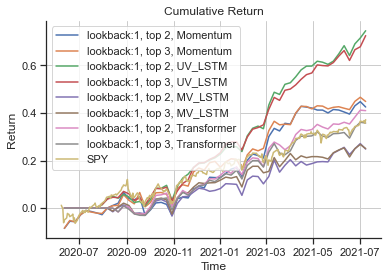

In [160]:
fig, ax = plt.subplots()
ax.set_title('Cumulative Return')

ax.set(xlabel='Time', ylabel='Return')
ax.grid(True, which='both')
seaborn.despine(ax=ax, offset=0)

# simple momentum
df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_return_table(df, t, n).loc[portfolio_return_table(df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", Momentum")
        ax.legend()

# univariate LSTM model
predict_df = LSTM_prediction_return_table
original_df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_return_table_for_prediction(original_df, predict_df, t, n).loc[portfolio_return_table_for_prediction(original_df, predict_df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", UV_LSTM")
        ax.legend()

# multivariate LSTM model
predict_df = mv_lstm_prediction_return_table
original_df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_return_table_for_prediction(original_df, predict_df, t, n).loc[portfolio_return_table_for_prediction(original_df, predict_df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", MV_LSTM")
        ax.legend()
        
# transformer model       
predict_df = TFT_prediction_return_table
original_df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_return_table_for_prediction(original_df, predict_df, t, n).loc[portfolio_return_table_for_prediction(original_df, predict_df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", Transformer")
        ax.legend()

# use SPY as the benchmark

df_extract = get_historical_data('SPY', start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
benchmark_return = pd.to_numeric(df_extract.changePercent)

benchmark_data = (1+benchmark_return.loc[benchmark_return.index > '2020-06-05']).cumprod()-1
ax.plot(benchmark_data, label = 'SPY')
ax.legend()

In [169]:
# let's take a look of the winners in each model

# real winner
df = resample_risk_adjusted_return_table(return_table, t)
ranking = resample_risk_adjusted_return_table(df, t).rank(axis=1, na_option='keep', ascending = False)
original_rank = list(range (1, len(df.columns)+1))
replace_rank = [1]*n + [0]*(len(df.columns)-n)

ranking_matrix = ranking.replace(original_rank, replace_rank)# replace_rank
ranking_matrix.apply(lambda row: row[row == 1].index, axis=1).loc[ranking_matrix.index > '2021-01-01']

2021-01-08     Index(['MGK', 'XLI', 'XLK'], dtype='object')
2021-01-15     Index(['SDY', 'VHT', 'VBK'], dtype='object')
2021-01-22    Index(['SPLV', 'VIG', 'VIS'], dtype='object')
2021-01-29     Index(['MGV', 'VOX', 'XBI'], dtype='object')
2021-02-05           Index(['SPLV', 'XLK'], dtype='object')
2021-02-12    Index(['SPLV', 'VDC', 'XLI'], dtype='object')
2021-02-19     Index(['SDY', 'VIS', 'XLI'], dtype='object')
2021-02-26     Index(['VDE', 'VFH', 'XME'], dtype='object')
2021-03-05    Index(['SPLV', 'VIG', 'XLI'], dtype='object')
2021-03-12     Index(['MGK', 'VUG', 'XLK'], dtype='object')
2021-03-19    Index(['SPLV', 'VHT', 'XLC'], dtype='object')
2021-03-26      Index(['VHT', 'VO', 'VUG'], dtype='object')
2021-04-02    Index(['SPLV', 'VIG', 'VOE'], dtype='object')
2021-04-09     Index(['SDY', 'VBK', 'VOE'], dtype='object')
2021-04-16     Index(['VDE', 'VUG', 'XLK'], dtype='object')
2021-04-23     Index(['VIG', 'VOE', 'XLI'], dtype='object')
2021-04-30     Index(['VIS', 'VYM', 'XLI

In [162]:
def show_winners(df, t, n):
    # for prediction model only
    # t is lookback period, n is top n sercurities we selected
    df_winners = momemtum_ranking_table_for_predict_return(df, t, n).loc[momemtum_ranking_table_for_predict_return(df, t, n).index> '2021-01-01 ']
    
    return df_winners.apply(lambda row: row[row == 1].index, axis=1)

In [167]:
# simple momentum
t = 1
n = 3
df_winners = momemtum_ranking_table(return_table, t, n).loc[momemtum_ranking_table(return_table, t, n).index> '2021-01-01 ']
df_winners.apply(lambda row: row[row == 1].index, axis=1)

2021-01-08     Index(['MGV', 'VPU', 'XLV'], dtype='object')
2021-01-15     Index(['VHT', 'VDE', 'XLV'], dtype='object')
2021-01-22     Index(['VDE', 'VNQ', 'VOE'], dtype='object')
2021-01-29    Index(['MTUM', 'VGT', 'XLK'], dtype='object')
2021-02-05     Index(['VNQ', 'VPU', 'XBI'], dtype='object')
2021-02-12     Index(['SDY', 'VOE', 'VOX'], dtype='object')
2021-02-19      Index(['VO', 'VOT', 'VOX'], dtype='object')
2021-02-26     Index(['VDE', 'VFH', 'VYM'], dtype='object')
2021-03-05     Index(['VDE', 'VFH', 'VBR'], dtype='object')
2021-03-12     Index(['SDY', 'VDE', 'VFH'], dtype='object')
2021-03-19     Index(['VIG', 'VBR', 'VNQ'], dtype='object')
2021-03-26    Index(['SPLV', 'XLC', 'XLV'], dtype='object')
2021-04-02    Index(['SPLV', 'VIG', 'VDC'], dtype='object')
2021-04-09    Index(['MTUM', 'VOX', 'XLC'], dtype='object')
2021-04-16    Index(['MGK', 'MTUM', 'VUG'], dtype='object')
2021-04-23      Index(['VB', 'VPU', 'XLB'], dtype='object')
2021-04-30     Index(['VHT', 'VNQ', 'XLV

In [164]:
# univariate LSTM model
show_winners(LSTM_prediction_return_table, 1, 3)


2021-01-08    Index(['SPLV', 'VFH', 'XLV'], dtype='object')
2021-01-15      Index(['VB', 'VFH', 'VYM'], dtype='object')
2021-01-22    Index(['SPLV', 'VFH', 'VNQ'], dtype='object')
2021-01-29     Index(['SPLV', 'VB', 'VNQ'], dtype='object')
2021-02-05     Index(['SPLV', 'VB', 'VNQ'], dtype='object')
2021-02-12      Index(['VNQ', 'VO', 'VOT'], dtype='object')
2021-02-19    Index(['SDY', 'SPLV', 'VFH'], dtype='object')
2021-02-26     Index(['VDE', 'VFH', 'VNQ'], dtype='object')
2021-03-05      Index(['VB', 'VDE', 'VFH'], dtype='object')
2021-03-12     Index(['SDY', 'VFH', 'VYM'], dtype='object')
2021-03-19    Index(['SPLV', 'VFH', 'VNQ'], dtype='object')
2021-03-26    Index(['SPLV', 'VDC', 'VNQ'], dtype='object')
2021-04-02    Index(['SPLV', 'VFH', 'VNQ'], dtype='object')
2021-04-09    Index(['SPLV', 'VFH', 'VNQ'], dtype='object')
2021-04-16     Index(['SPLV', 'VB', 'VFH'], dtype='object')
2021-04-23    Index(['SPLV', 'VNQ', 'XLV'], dtype='object')
2021-04-30      Index(['VB', 'VNQ', 'XLB

In [165]:
# multivariate LSTM model
show_winners(mv_lstm_prediction_return_table, 1, 3)

2021-01-08    Index(['SPLV', 'VOE', 'VPU'], dtype='object')
2021-01-15    Index(['SDY', 'SPLV', 'VIS'], dtype='object')
2021-01-22      Index(['VDE', 'VNQ', 'VV'], dtype='object')
2021-01-29    Index(['MTUM', 'MGV', 'XLI'], dtype='object')
2021-02-05    Index(['MTUM', 'VUG', 'XME'], dtype='object')
2021-02-12    Index(['SPLV', 'VOX', 'VUG'], dtype='object')
2021-02-19     Index(['MGC', 'VTV', 'VYM'], dtype='object')
2021-02-26     Index(['SDY', 'VGT', 'XLV'], dtype='object')
2021-03-05     Index(['VOT', 'VPU', 'VTV'], dtype='object')
2021-03-12     Index(['VIG', 'VCR', 'VNQ'], dtype='object')
2021-03-19     Index(['MGK', 'VDE', 'VIS'], dtype='object')
2021-03-26     Index(['VGT', 'VNQ', 'XLK'], dtype='object')
2021-04-02    Index(['MTUM', 'VNQ', 'VOX'], dtype='object')
2021-04-09     Index(['VDC', 'XBI', 'XME'], dtype='object')
2021-04-16     Index(['QQQ', 'VYM', 'XBI'], dtype='object')
2021-04-23     Index(['VDE', 'VIS', 'XLC'], dtype='object')
2021-04-30      Index(['MGK', 'VNQ', 'VV

In [166]:
# transformer model
show_winners(TFT_prediction_return_table, 1, 3)

2021-01-08    Index(['SPLV', 'XLC', 'XLV'], dtype='object')
2021-01-15     Index(['SDY', 'VBK', 'VUG'], dtype='object')
2021-01-22     Index(['VHT', 'VUG', 'XLV'], dtype='object')
2021-01-29     Index(['VHT', 'VGT', 'VOE'], dtype='object')
2021-02-05     Index(['VDE', 'VUG', 'XLV'], dtype='object')
2021-02-12     Index(['VUG', 'XLC', 'XLV'], dtype='object')
2021-02-19     Index(['SDY', 'VIS', 'XLC'], dtype='object')
2021-02-26     Index(['SPLV', 'VB', 'VOE'], dtype='object')
2021-03-05     Index(['VDE', 'VOE', 'XLC'], dtype='object')
2021-03-12     Index(['VDE', 'VOE', 'VUG'], dtype='object')
2021-03-19     Index(['MGC', 'VDE', 'VUG'], dtype='object')
2021-03-26     Index(['VDE', 'VUG', 'XLC'], dtype='object')
2021-04-02     Index(['MGC', 'XLC', 'XLV'], dtype='object')
2021-04-09     Index(['MGC', 'VUG', 'XLC'], dtype='object')
2021-04-16     Index(['MGK', 'VIS', 'VUG'], dtype='object')
2021-04-23     Index(['VIS', 'VUG', 'XLC'], dtype='object')
2021-04-30     Index(['VIG', 'VOE', 'VUG